In [65]:
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import Rectangle
import seaborn as sns
import json
import argparse
from pathlib import Path
from sklearn.metrics import mean_absolute_error, r2_score
from matplotlib.ticker import FuncFormatter
import optuna
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate,
    plot_slice
)

# Configuración de estilo para los gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

import sys
from pathlib import Path

# En notebooks, usar el directorio actual como base
notebook_dir = Path.cwd()
project_root = notebook_dir.parent if notebook_dir.name == 'models' else notebook_dir
sys.path.append(str(project_root))

from models import (
    ModelConfig,
    ATCAircraftDataLoader,
    AircraftDataPreprocessor,
    AircraftFeatureEngineer,
    AircraftForecaster,
    ARIMAModel,
    ProphetModel,
    RandomForestModel,
    LSTMModel,
    XGBoostModel,
    EnsembleModel,
    NewsDataLoader,
    WeatherDataLoader
)

In [73]:
json_file_path = "train_results/daily/comprehensive_training_results.json"  
storage_url = "optuna_storage/aircraft_forecasting_airlinesOneHot_NewsAggregated_h1.db"

---
## Análisis de las Configuraciones de la Base de Datos
---

In [2]:
def load_results(json_file_path):
    """
    Carga resultados desde un archivo JSON y genera visualizaciones.
    
    Args:
        json_file_path: Ruta al archivo JSON con resultados
    """
    try:
        # Cargar resultados
        with open(json_file_path, 'r', encoding='utf-8') as f:
            all_results = json.load(f)
        
        print(f" Resultados cargados desde: {json_file_path}")
        print(f" Total de configuraciones: {len(all_results)}")
        
        # Filtrar resultados exitosos
        successful_results = [r for r in all_results if r.get('best_model') != 'ERROR']
        print(f" Configuraciones exitosas: {len(successful_results)}")
        
        # Extraer todos los resultados individuales de modelos
        formatted_results = []
        model_names = set()
        
        for result in successful_results:
            config = result['config']
            all_models = result.get('all_results', {})
            
            for model_name, model_data in all_models.items():
                if model_data.get('success', False):
                    metrics = model_data.get('metrics', {})
                    formatted_results.append({
                        'config': config,
                        'model': model_name,
                        'mae': metrics.get('mae', 0),
                        'rmse': metrics.get('rmse', 0),
                        'r2': metrics.get('r2', 0)
                    })
                    model_names.add(model_name)
        
        print(f" Modelos encontrados: {', '.join(sorted(model_names))}")
        
        if not formatted_results:
            print(" No hay resultados para visualizar")
            return
        
        # Convertir a DataFrame
        df_results = pd.DataFrame(formatted_results)
        
        print(f" Total de resultados: {len(df_results)}")
        print(f"  Configuraciones: {df_results['config'].nunique()}")
        print(f" Modelos: {df_results['model'].nunique()}")

        return df_results, all_results
        
    except FileNotFoundError:
        print(f"❌ Error: Archivo no encontrado: {json_file_path}")
    except json.JSONDecodeError:
        print(f"❌ Error: El archivo {json_file_path} no contiene JSON válido")
    except Exception as e:
        print(f"❌ Error procesando resultados: {e}")

In [3]:
def shorten_config_names(configs):
    """
    Crea un mapeo de nombres largos a nombres cortos para las configuraciones.
    """
    config_map = {
        'BASELINE': 'BASELINE',
        'AEROLINEAS(OneHot=False)': 'AERO(NoOH)',
        'AEROLINEAS(OneHot=True)': 'AERO(OH)',
        'NEWS(OneHot)': 'NEWS(OH)',
        'NEWS(Aggregated)': 'NEWS(Agg)',
        'WEATHER': 'WEATHER',
        'AEROLINEAS(OneHot=False) y WEATHER': 'W+AERO(NoOH)',
        'AEROLINEAS(OneHot=True) y WEATHER': 'W+AERO(OH)',
        'NEWS(OneHot) y WEATHER': 'W+NEWS(OH)',
        'NEWS(Aggregated) y WEATHER': 'W+NEWS(Agg)',
        'AEROLINEAS(OneHot=False) y NEWS(OneHot)': 'AERO(NoOH)+NEWS(OH)',
        'AEROLINEAS(OneHot=True) y NEWS(OneHot)': 'AERO(OH)+NEWS(OH)',
        'AEROLINEAS(OneHot=False) y NEWS(Aggregated)': 'AERO(NoOH)+NEWS(Agg)',
        'AEROLINEAS(OneHot=True) y NEWS(Aggregated)': 'AERO(OH)+NEWS(Agg)',
        'AEROLINEAS(OneHot=False) y NEWS(OneHot) y WEATHER': 'W+AERO(NoOH)+NEWS(OH)',
        'AEROLINEAS(OneHot=True) y NEWS(OneHot) y WEATHER': 'W+AERO(OH)+NEWS(OH)',
        'AEROLINEAS(OneHot=False) y NEWS(Aggregated) y WEATHER': 'W+AERO(NoOH)+NEWS(Agg)',
        'AEROLINEAS(OneHot=True) y NEWS(Aggregated) y WEATHER': 'W+AERO(OH)+NEWS(Agg)'
    }
    
    # Para cualquier configuración no mapeada, crear un nombre corto
    shortened_map = {}
    for config in configs:
        if config in config_map:
            shortened_map[config] = config_map[config]
        else:
            # Acortar manualmente si no está en el mapa
            shortened_map[config] = config[:20] + '...' if len(config) > 20 else config
    
    return shortened_map


In [4]:
def create_heatmaps(df):
    """
    Crea heatmaps para MAE, RMSE y R² por modelo y configuración.
    """
    # Crear mapeo de configuraciones
    config_map = shorten_config_names(df['config'].unique())
    df['config_short'] = df['config'].map(config_map)
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))
    fig.suptitle('Heatmaps de Métricas por Modelo y Configuración', fontsize=16, fontweight='bold')
    
    # Pivot tables para cada métrica - asegurarse de incluir todas las configuraciones
    pivot_mae = df.pivot_table(values='mae', index='config_short', columns='model', aggfunc='mean', fill_value=np.nan)
    pivot_rmse = df.pivot_table(values='rmse', index='config_short', columns='model', aggfunc='mean', fill_value=np.nan)
    pivot_r2 = df.pivot_table(values='r2', index='config_short', columns='model', aggfunc='mean', fill_value=np.nan)
    
    # Heatmap MAE - colores más diferenciados
    sns.heatmap(pivot_mae, annot=True, fmt='.1f', cmap='RdYlBu_r', ax=axes[0], 
                cbar_kws={'label': 'MAE'})
    axes[0].set_title('MAE (más bajo es mejor)', fontweight='bold')
    axes[0].set_xlabel('Modelo')
    axes[0].set_ylabel('Configuración')
    
    # Heatmap RMSE - colores más diferenciados
    sns.heatmap(pivot_rmse, annot=True, fmt='.1f', cmap='RdYlBu_r', ax=axes[1],
                cbar_kws={'label': 'RMSE'})
    axes[1].set_title('RMSE (más bajo es mejor)', fontweight='bold')
    axes[1].set_xlabel('Modelo')
    axes[1].set_ylabel('')
    
    # Heatmap R² - colores más diferenciados
    sns.heatmap(pivot_r2, annot=True, fmt='.2f', cmap='RdYlGn', ax=axes[2],
                cbar_kws={'label': 'R²'}, center=0)
    axes[2].set_title('R² (más alto es mejor)', fontweight='bold')
    axes[2].set_xlabel('Modelo')
    axes[2].set_ylabel('')
    
    # Rotar etiquetas para mejor legibilidad
    for ax in axes:
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        plt.setp(ax.get_yticklabels(), rotation=0)
    
    # Añadir leyenda útil de configuraciones
    legend_text = "Leyenda de Configuraciones:\n" + "\n".join([f"{short}: {long}" for long, short in config_map.items() if long in df['config'].unique()])
    fig.text(0.02, 0.02, legend_text, fontsize=8, verticalalignment='bottom', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
  
    plt.tight_layout(rect=[0, 0.20, 1, 0.95])

In [5]:
def create_combined_plots(df):
    """
    Crea una imagen combinada con las gráficas solicitadas.
    """
    # Crear mapeo de configuraciones
    config_map = shorten_config_names(df['config'].unique())
    df['config_short'] = df['config'].map(config_map)
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Análisis Comparativo de Resultados', fontsize=16, fontweight='bold')
    
    # 1. Mejora relativa vs baseline
    ax1 = axes[0, 0]
    baseline_data = df[df['config'] == 'BASELINE']
    if baseline_data.empty:
        print("⚠️  No se encontró configuración BASELINE")
        baseline_mae = df['mae'].mean()  # Usar promedio general como fallback
    else:
        baseline_mae = baseline_data['mae'].mean()
    
    config_improvement = df.groupby('config')['mae'].mean().sort_values()
    improvement_pct = ((baseline_mae - config_improvement) / baseline_mae * 100).sort_values()
    
    # Mapear configuraciones a nombres cortos para el gráfico
    improvement_pct.index = improvement_pct.index.map(config_map)
    
    colors = ['green' if x > 0 else 'red' for x in improvement_pct.values]
    bars = ax1.barh(range(len(improvement_pct)), improvement_pct.values, color=colors, alpha=0.7)
    ax1.set_title('Mejora Relativa vs Baseline (%)', fontweight='bold', fontsize=12)
    ax1.set_xlabel('Mejora (%)', fontsize=10)
    ax1.set_ylabel('Configuración', fontsize=10)
    ax1.set_yticks(range(len(improvement_pct)))
    ax1.set_yticklabels(improvement_pct.index, fontsize=8)
    ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    # Añadir valores
    for bar, value in zip(bars, improvement_pct.values):
        ax1.text(bar.get_width() + (1 if value >= 0 else -1), bar.get_y() + bar.get_height()/2, 
                f'{value:.1f}%', ha='left' if value >= 0 else 'right', va='center', 
                fontsize=8, fontweight='bold')
    
    # 2. MAE promedio por modelo
    ax2 = axes[0, 1]
    model_mae = df.groupby('model')['mae'].mean().sort_values()
    bars = ax2.bar(model_mae.index, model_mae.values, color='skyblue', edgecolor='navy', alpha=0.7)
    ax2.set_title('MAE Promedio por Modelo', fontweight='bold', fontsize=12)
    ax2.set_ylabel('MAE', fontsize=10)
    ax2.set_xlabel('Modelo', fontsize=10)
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=9)
    
    # Añadir valores sobre las barras
    for bar, value in zip(bars, model_mae.values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                f'{value:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # 3. MAE promedio por configuración
    ax3 = axes[1, 0]
    config_mae = df.groupby('config')['mae'].mean().sort_values()
    config_mae.index = config_mae.index.map(config_map)  # Mapear a nombres cortos
    
    bars = ax3.barh(range(len(config_mae)), config_mae.values, color='lightcoral', alpha=0.7)
    ax3.set_title('MAE Promedio por Configuración', fontweight='bold', fontsize=12)
    ax3.set_xlabel('MAE', fontsize=10)
    ax3.set_ylabel('Configuración', fontsize=10)
    ax3.set_yticks(range(len(config_mae)))
    ax3.set_yticklabels(config_mae.index, fontsize=8)
    
    # Añadir valores
    for bar, value in zip(bars, config_mae.values):
        ax3.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2, 
                f'{value:.1f}', ha='left', va='center', fontweight='bold', fontsize=8)
    
    # 4. Mejor modelo por configuración (sin texto sobre barras)
    ax4 = axes[1, 1]
    best_results = df.loc[df.groupby('config')['mae'].idxmin()].sort_values('mae')
    best_results = best_results.copy()
    best_results['config_short'] = best_results['config'].map(config_map)
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(best_results)))
    bars = ax4.bar(range(len(best_results)), best_results['mae'], color=colors, alpha=0.8)
    ax4.set_title('Mejor Modelo por Configuración', fontweight='bold', fontsize=12)
    ax4.set_ylabel('MAE', fontsize=10)
    ax4.set_xlabel('Configuración', fontsize=10)
    ax4.set_xticks(range(len(best_results)))
    ax4.set_xticklabels(best_results['config_short'], rotation=45, ha='right', fontsize=8)
    
    # Sin texto sobre las barras como solicitaste
    
    # Añadir leyenda útil de configuraciones
    if len(config_map) > 1:  # Solo si hay múltiples configuraciones
        legend_text = "Configuraciones:\n" + "\n".join([f"• {short}: {long}" for long, short in config_map.items() if long in df['config'].unique()])
        fig.text(0.02, 0.02, legend_text, fontsize=6, verticalalignment='bottom', 
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.9))
        print("📋 Leyenda de configuraciones añadida para facilitar lectura")
    
    plt.tight_layout(rect=[0, 0.20, 1, 0.95])

In [6]:
def generate_training_summary(df):
    """
    Genera un resumen detallado de los resultados de entrenamiento en un archivo TXT.
    
    Args:
        df: DataFrame con los resultados de entrenamiento
        output_file: Ruta del archivo de salida (default: 'train_results/training_summary.txt')
    """
    import os
    from datetime import datetime
    
    # Obtener fecha y hora actual
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    
    # Iniciar contenido del resumen
    summary_content = []
    summary_content.append("=" * 80)
    summary_content.append("RESUMEN DE RESULTADOS DE ENTRENAMIENTO")
    summary_content.append(f"Generado: {timestamp}")
    summary_content.append("=" * 80)
    summary_content.append("")
    
    # Estadísticas generales
    summary_content.append("📊 ESTADÍSTICAS GENERALES")
    summary_content.append("-" * 40)
    summary_content.append(f"Total de resultados: {len(df)}")
    summary_content.append(f"Configuraciones evaluadas: {df['config'].nunique()}")
    summary_content.append(f"Modelos evaluados: {df['model'].nunique()}")
    summary_content.append(f"Modelos: {', '.join(sorted(df['model'].unique()))}")
    summary_content.append("")
    
    # Mejor modelo global
    summary_content.append("🏆 MEJOR MODELO GLOBAL")
    summary_content.append("-" * 40)
    best_overall = df.loc[df['mae'].idxmin()]
    summary_content.append(f"Modelo: {best_overall['model']}")
    summary_content.append(f"Configuración: {best_overall['config']}")
    summary_content.append(f"MAE: {best_overall['mae']:.4f}")
    summary_content.append(f"RMSE: {best_overall['rmse']:.4f}")
    summary_content.append(f"R²: {best_overall['r2']:.4f}")
    summary_content.append("")
    
    # Mejores modelos por configuración
    summary_content.append("🎯 MEJORES MODELOS POR CONFIGURACIÓN")
    summary_content.append("-" * 40)
    best_by_config = df.loc[df.groupby('config')['mae'].idxmin()].sort_values('mae')
    for _, row in best_by_config.iterrows():
        summary_content.append(f"{row['config']}:")
        summary_content.append(f"  • Modelo: {row['model']} (MAE: {row['mae']:.4f})")
        summary_content.append(f"  • RMSE: {row['rmse']:.4f}, R²: {row['r2']:.4f}")
        summary_content.append("")
    
    # Mejores modelos por tipo de modelo
    summary_content.append("🔧 MEJORES MODELOS POR TIPO")
    summary_content.append("-" * 40)
    for model in sorted(df['model'].unique()):
        best_model = df[df['model'] == model].loc[df[df['model'] == model]['mae'].idxmin()]
        summary_content.append(f"{model}:")
        summary_content.append(f"  • Configuración: {best_model['config']}")
        summary_content.append(f"  • MAE: {best_model['mae']:.4f}")
        summary_content.append(f"  • RMSE: {best_model['rmse']:.4f}, R²: {best_model['r2']:.4f}")
        summary_content.append("")
    
    # Análisis por configuración (promedios)
    summary_content.append("📈 ANÁLISIS POR CONFIGURACIÓN (PROMEDIOS)")
    summary_content.append("-" * 40)
    config_stats = df.groupby('config').agg({
        'mae': ['mean', 'std', 'min', 'max'],
        'rmse': ['mean', 'std'],
        'r2': ['mean', 'std']
    }).round(4)
    
    for config in sorted(df['config'].unique()):
        config_data = df[df['config'] == config]
        summary_content.append(f"{config}:")
        summary_content.append(f"  • MAE: {config_data['mae'].mean():.4f} ± {config_data['mae'].std():.4f}")
        summary_content.append(f"    - Mejor: {config_data['mae'].min():.4f}, Peor: {config_data['mae'].max():.4f}")
        summary_content.append(f"  • RMSE: {config_data['rmse'].mean():.4f} ± {config_data['rmse'].std():.4f}")
        summary_content.append(f"  • R²: {config_data['r2'].mean():.4f} ± {config_data['r2'].std():.4f}")
        summary_content.append("")
    
    # Ranking de configuraciones por MAE promedio
    summary_content.append("🏅 RANKING DE CONFIGURACIONES (POR MAE PROMEDIO)")
    summary_content.append("-" * 40)
    config_ranking = df.groupby('config')['mae'].mean().sort_values()
    for i, (config, mae) in enumerate(config_ranking.items(), 1):
        summary_content.append(f"{i:2d}. {config}: {mae:.4f}")
    summary_content.append("")
    
    # Análisis de mejora vs baseline (si existe BASELINE)
    baseline_data = df[df['config'] == 'BASELINE']
    if not baseline_data.empty:
        summary_content.append("📊 ANÁLISIS DE MEJORA VS BASELINE")
        summary_content.append("-" * 40)
        baseline_mae = baseline_data['mae'].mean()
        summary_content.append(f"MAE Baseline: {baseline_mae:.4f}")
        summary_content.append("")
        
        config_improvement = df.groupby('config')['mae'].mean().sort_values()
        improvement_pct = ((baseline_mae - config_improvement) / baseline_mae * 100).sort_values(ascending=False)
        
        summary_content.append("Mejora relativa vs Baseline:")
        for config, improvement in improvement_pct.items():
            if config != 'BASELINE':
                arrow = "📈" if improvement > 0 else "📉"
                summary_content.append(f"  {arrow} {config}: {improvement:+.2f}%")
        summary_content.append("")
    
    # Modelos más consistentes (menor desviación estándar en MAE)
    summary_content.append("🎯 MODELOS MÁS CONSISTENTES (MENOR VARIABILIDAD)")
    summary_content.append("-" * 40)
    model_consistency = df.groupby('model')['mae'].std().sort_values()
    for model, std in model_consistency.items():
        mean_mae = df[df['model'] == model]['mae'].mean()
        summary_content.append(f"{model}: σ={std:.4f} (μ={mean_mae:.4f})")
    summary_content.append("")
    
    # Correlación entre métricas
    summary_content.append("🔗 CORRELACIÓN ENTRE MÉTRICAS")
    summary_content.append("-" * 40)
    correlation_matrix = df[['mae', 'rmse', 'r2']].corr()
    summary_content.append(f"MAE vs RMSE: {correlation_matrix.loc['mae', 'rmse']:.4f}")
    summary_content.append(f"MAE vs R²: {correlation_matrix.loc['mae', 'r2']:.4f}")
    summary_content.append(f"RMSE vs R²: {correlation_matrix.loc['rmse', 'r2']:.4f}")
    summary_content.append("")
    
    # Conclusiones
    summary_content.append("📝 CONCLUSIONES")
    summary_content.append("-" * 40)
    
    best_config = df.groupby('config')['mae'].mean().idxmin()
    most_consistent_model = df.groupby('model')['mae'].std().idxmin()
    
    summary_content.append(f"• La mejor configuración general es: {best_config}")
    summary_content.append(f"• El modelo más consistente es: {most_consistent_model}")
    summary_content.append(f"• El mejor modelo absoluto es: {best_overall['model']} con {best_overall['config']}")
    
    # Recomendaciones
    summary_content.append("")
    summary_content.append("💡 RECOMENDACIONES")
    summary_content.append("-" * 40)
    
    if not baseline_data.empty:
        best_improvement = improvement_pct.drop('BASELINE', errors='ignore').idxmax()
        if improvement_pct[best_improvement] > 0:
            summary_content.append(f"• Usar {best_improvement} para mejores resultados vs baseline")
        else:
            summary_content.append("• Ninguna configuración supera al baseline")
    
    summary_content.append(f"• Para máxima consistencia: {most_consistent_model}")
    summary_content.append(f"• Para mejor rendimiento absoluto: {best_overall['model']} con {best_overall['config']}")
    
    summary_content.append("")
    summary_content.append("=" * 80)
    summary_content.append("FIN DEL RESUMEN")
    summary_content.append("=" * 80)
    
    print(f"   - Total de líneas: {len(summary_content)}")
    print(f"   - Mejor modelo: {best_overall['model']} (MAE: {best_overall['mae']:.4f})")
    
    return summary_content


In [ ]:
def visualize_comprehensive_results(all_results):
    """
    Visualiza los resultados del entrenamiento comprehensivo.
    """
    
    # Convertir a DataFrame para análisis
    df_results = pd.DataFrame(all_results)
    
    # Filtrar resultados exitosos (excluir errores)
    successful_results = df_results[df_results['best_model'] != 'ERROR']
    
    if successful_results.empty:
        print("No hay resultados exitosos para visualizar")
        return
    
    # Crear figura con múltiples gráficos
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle('Análisis Comprehensivo de Modelos - Todas las Combinaciones', fontsize=16, fontweight='bold')
    
    # 1. Mejor MAE por configuración
    ax1 = axes[0, 0]
    sorted_by_mae = successful_results.sort_values('best_mae')
    bars = ax1.barh(range(len(sorted_by_mae)), sorted_by_mae['best_mae'], 
                    color='lightcoral', alpha=0.7)
    ax1.set_title('Mejor MAE por Configuración', fontweight='bold')
    ax1.set_xlabel('MAE')
    ax1.set_ylabel('Configuración')
    ax1.set_yticks(range(len(sorted_by_mae)))
    
    # Acortar etiquetas para legibilidad
    config_labels = []
    for config in sorted_by_mae['config']:
        if len(config) > 30:
            config_labels.append(config[:30] + '...')
        else:
            config_labels.append(config)
    ax1.set_yticklabels(config_labels, fontsize=8)
    
    # Añadir valores
    for i, (bar, value) in enumerate(zip(bars, sorted_by_mae['best_mae'])):
        ax1.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2, 
                f'{value:.1f}', ha='left', va='center', fontweight='bold', fontsize=8)
    
    # 2. Mejor modelo por configuración
    ax2 = axes[0, 1]
    model_counts = successful_results['best_model'].value_counts()
    colors = plt.cm.Set3(np.linspace(0, 1, len(model_counts)))
    wedges, texts, autotexts = ax2.pie(model_counts.values, labels=model_counts.index, 
                                      autopct='%1.1f%%', colors=colors, startangle=90)
    ax2.set_title('Distribución de Mejores Modelos', fontweight='bold')
    
    # 3. Impacto de cada feature
    ax3 = axes[1, 0]
    
    # Analizar impacto de cada feature
    feature_impact = {
        'AEROLINEAS': {'with': [], 'without': []},
        'NEWS': {'with': [], 'without': []}, 
        'WEATHER': {'with': [], 'without': []}
    }
    
    # Iterar sobre las filas del DataFrame
    for _, result in successful_results.iterrows():
        # AEROLINEAS
        if result['acids_param'] is not None:
            feature_impact['AEROLINEAS']['with'].append(result['best_mae'])
        else:
            feature_impact['AEROLINEAS']['without'].append(result['best_mae'])
        
        # NEWS
        if result['news_param'] is not None:
            feature_impact['NEWS']['with'].append(result['best_mae'])
        else:
            feature_impact['NEWS']['without'].append(result['best_mae'])
        
        # WEATHER
        if result['weather_param']:
            feature_impact['WEATHER']['with'].append(result['best_mae'])
        else:
            feature_impact['WEATHER']['without'].append(result['best_mae'])
    
    # Crear box plot comparativo
    feature_data = []
    feature_labels = []
    
    for feature, data in feature_impact.items():
        if data['with'] and data['without']:
            feature_data.extend(data['with'])
            feature_labels.extend([f'{feature} (con)'] * len(data['with']))
            feature_data.extend(data['without'])
            feature_labels.extend([f'{feature} (sin)'] * len(data['without']))
    
    if feature_data:
        df_feature = pd.DataFrame({'MAE': feature_data, 'Configuración': feature_labels})
        sns.boxplot(data=df_feature, x='Configuración', y='MAE', ax=ax3)
        ax3.set_title('Impacto de Features en MAE', fontweight='bold')
        ax3.tick_params(axis='x', rotation=45)
    
    # 4. Evolución del rendimiento
    ax4 = axes[1, 1]
    
    # Ordenar resultados por complejidad (número de features)
    complexity_scores = []
    for _, result in successful_results.iterrows():
        complexity = 0
        if result['acids_param'] is not None:
            complexity += 1
        if result['news_param'] is not None:
            complexity += 1
        if result['weather_param']:
            complexity += 1
        complexity_scores.append(complexity)
    
    df_complexity = successful_results.copy()
    df_complexity['complexity'] = complexity_scores
    
    # Agrupar por complejidad
    complexity_stats = df_complexity.groupby('complexity')['best_mae'].agg(['mean', 'std', 'count'])
    
    x_pos = range(len(complexity_stats))
    bars = ax4.bar(x_pos, complexity_stats['mean'], yerr=complexity_stats['std'], 
                    capsize=5, alpha=0.7, color='skyblue', edgecolor='navy')
    
    ax4.set_title('Rendimiento vs Complejidad', fontweight='bold')
    ax4.set_xlabel('Número de Features')
    ax4.set_ylabel('MAE Promedio')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels([f'{i} features' for i in complexity_stats.index])
    
    # Añadir valores
    for i, (bar, mean, count) in enumerate(zip(bars, complexity_stats['mean'], complexity_stats['count'])):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                f'{mean:.1f}\n(n={count})', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    # plt.savefig('train_results/comprehensive_training_analysis.png', dpi=300, bbox_inches='tight')
    # print(f"\n📊 Análisis guardado en: train_results/comprehensive_training_analysis.png")
    plt.show() 


In [ ]:
df_results, all_results = load_results(json_file_path)
generate_training_summary(df_results)

 Resultados cargados desde: train_results/daily/comprehensive_training_results.json
 Total de configuraciones: 18
 Configuraciones exitosas: 18
 Modelos encontrados: arima, ensemble, lstm, prophet, random_forest, xgboost
 Total de resultados: 108
  Configuraciones: 18
 Modelos: 6
   - Total de líneas: 310
   - Mejor modelo: xgboost (MAE: 121.8539)


['================================================================================',
 'RESUMEN DE RESULTADOS DE ENTRENAMIENTO',
 'Generado: 2026-01-11 11:25:03',
 '================================================================================',
 '',
 '📊 ESTADÍSTICAS GENERALES',
 '----------------------------------------',
 'Total de resultados: 108',
 'Configuraciones evaluadas: 18',
 'Modelos evaluados: 6',
 'Modelos: arima, ensemble, lstm, prophet, random_forest, xgboost',
 '',
 '🏆 MEJOR MODELO GLOBAL',
 '----------------------------------------',
 'Modelo: xgboost',
 'Configuración: AEROLINEAS(OneHot=True) y NEWS(Aggregated)',
 'MAE: 121.8539',
 'RMSE: 178.5187',
 'R²: 0.3866',
 '',
 '🎯 MEJORES MODELOS POR CONFIGURACIÓN',
 '----------------------------------------',
 'AEROLINEAS(OneHot=True) y NEWS(Aggregated):',
 '  • Modelo: xgboost (MAE: 121.8539)',
 '  • RMSE: 178.5187, R²: 0.3866',
 '',
 'AEROLINEAS(OneHot=True) y NEWS(OneHot):',
 '  • Modelo: xgboost (MAE: 121.9678)',
 '  • 


📊 Análisis guardado en: train_results/comprehensive_training_analysis.png


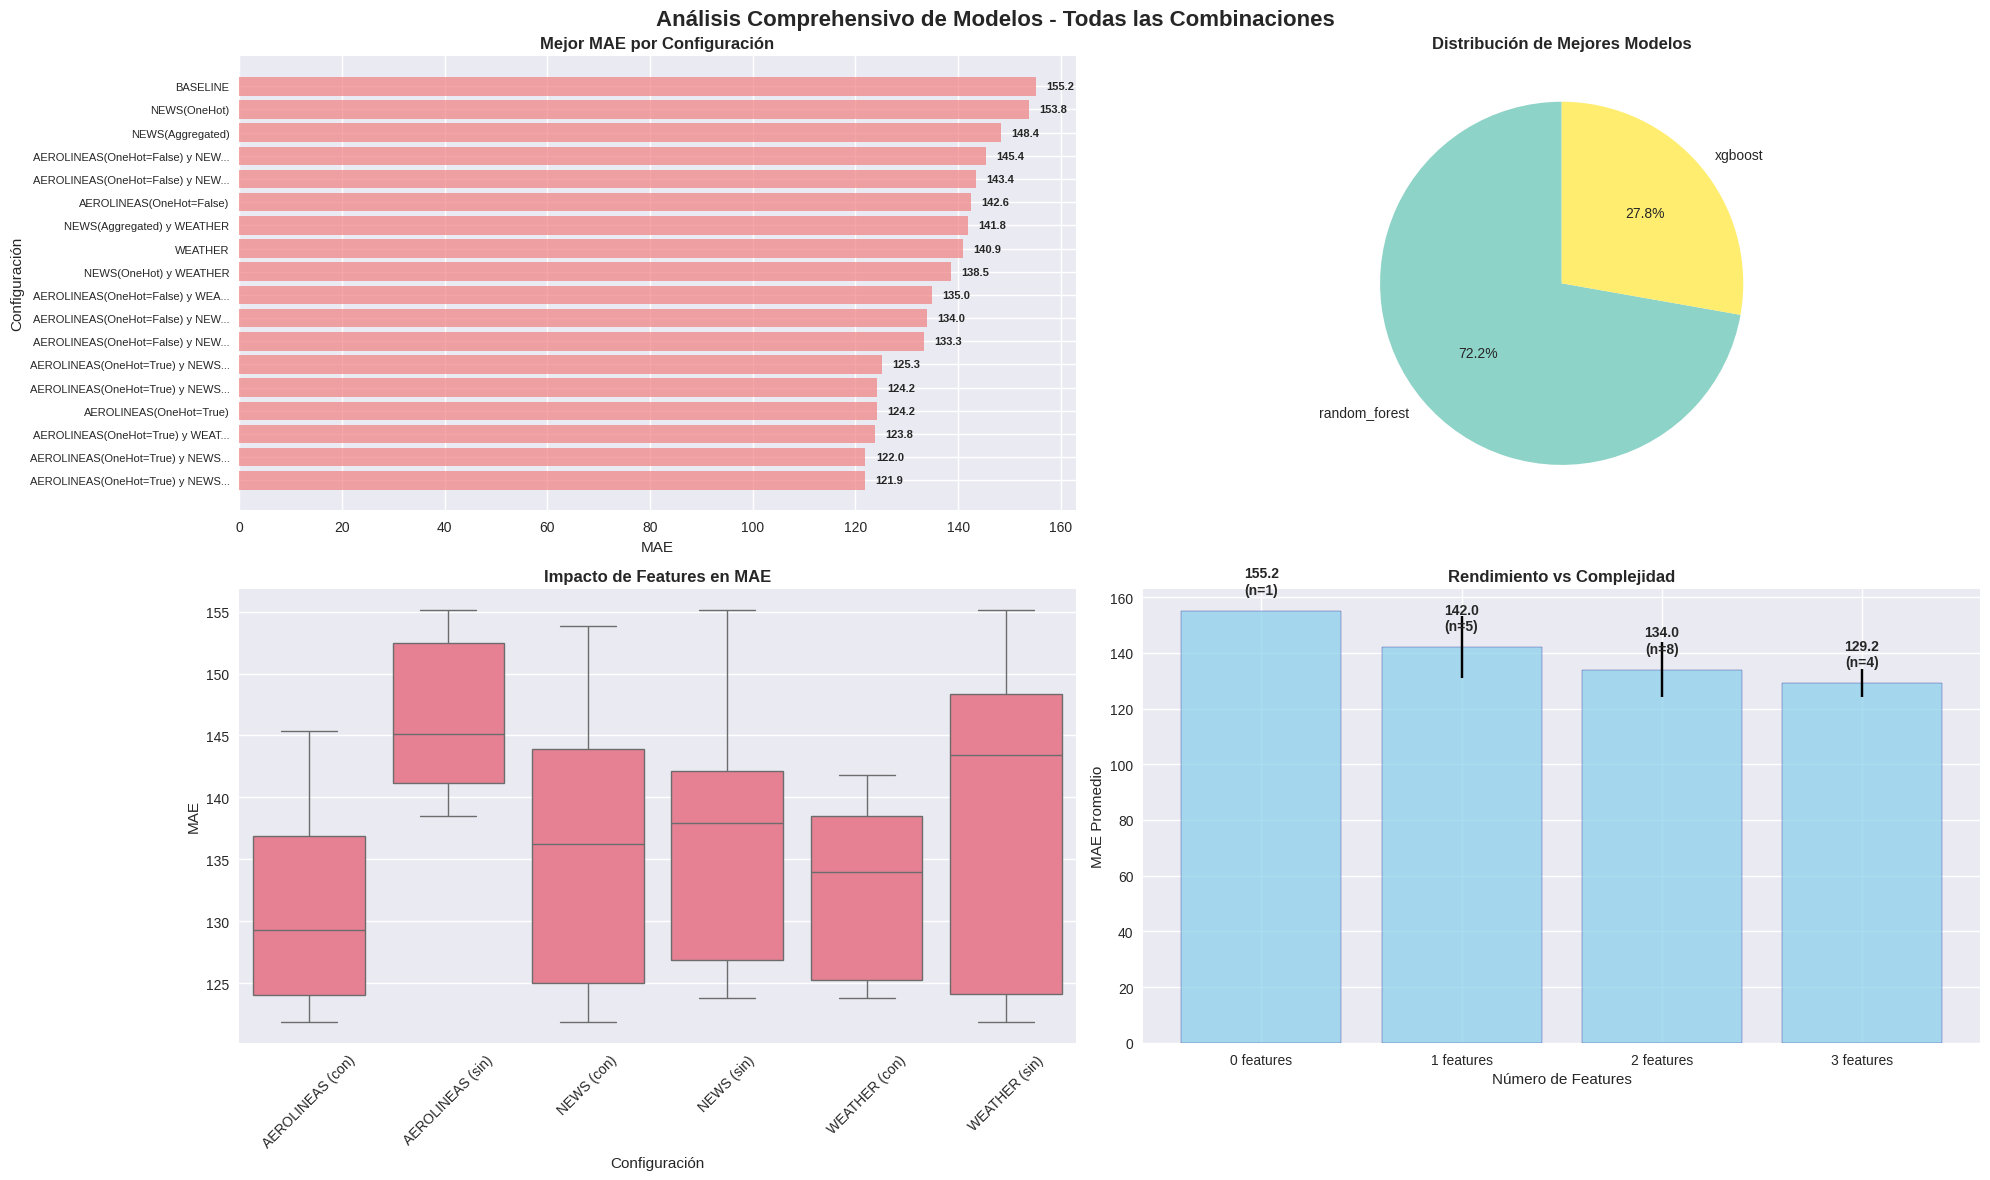

In [12]:
visualize_comprehensive_results(all_results)

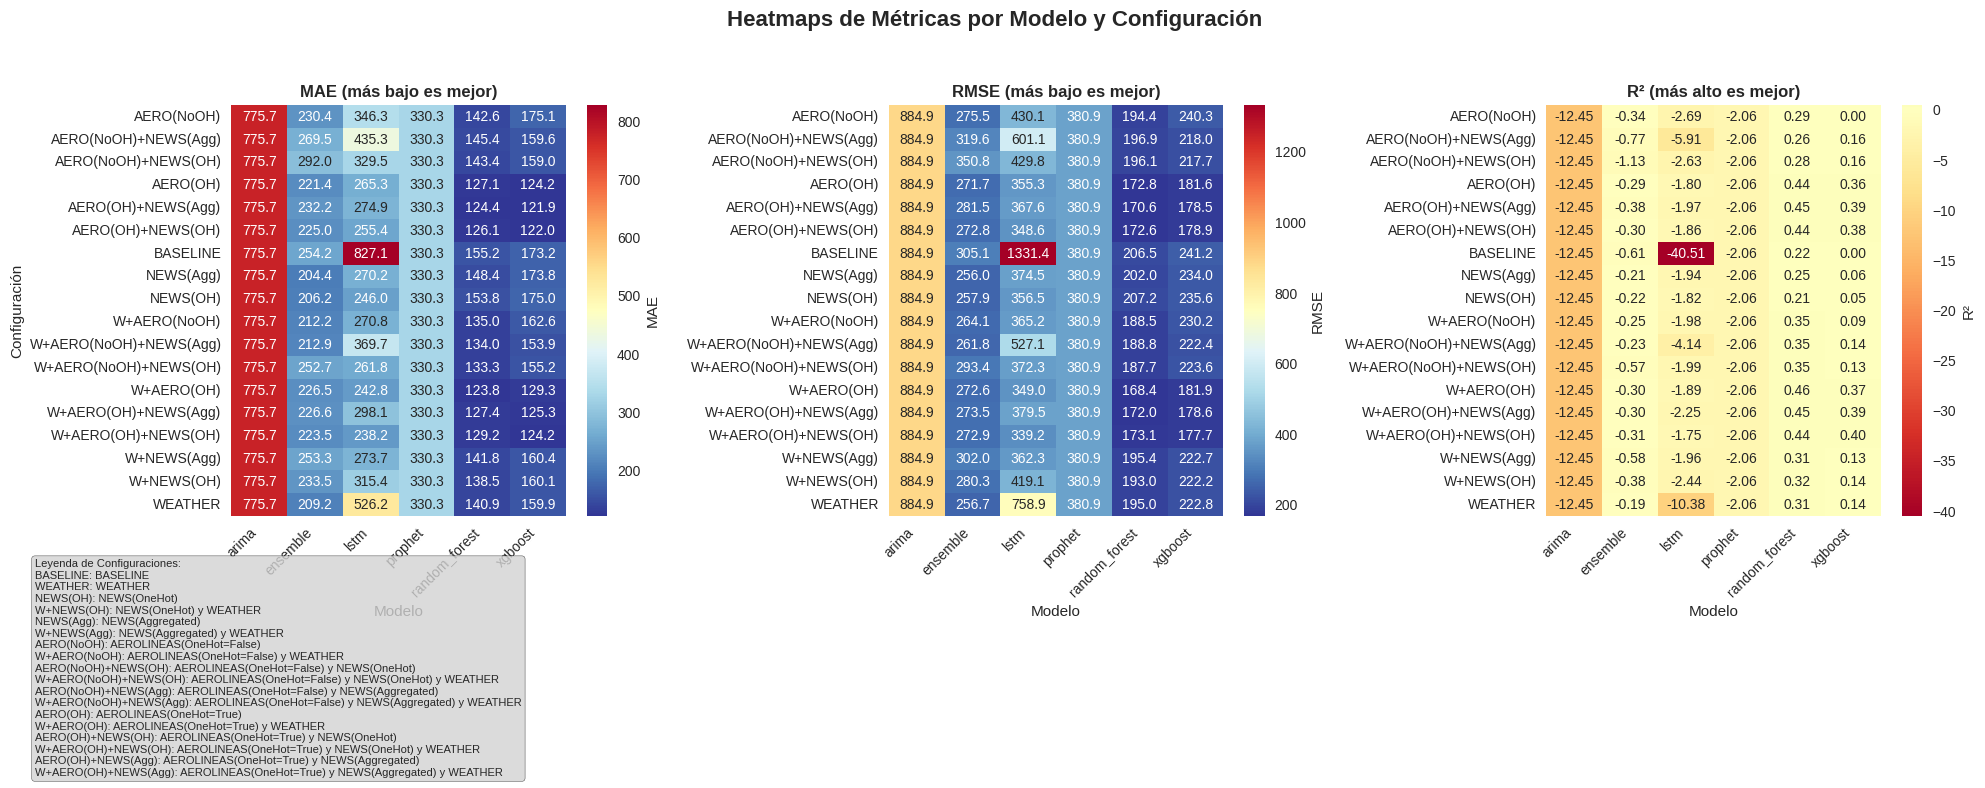

In [ ]:
create_heatmaps(df_results)

📋 Leyenda de configuraciones añadida para facilitar lectura


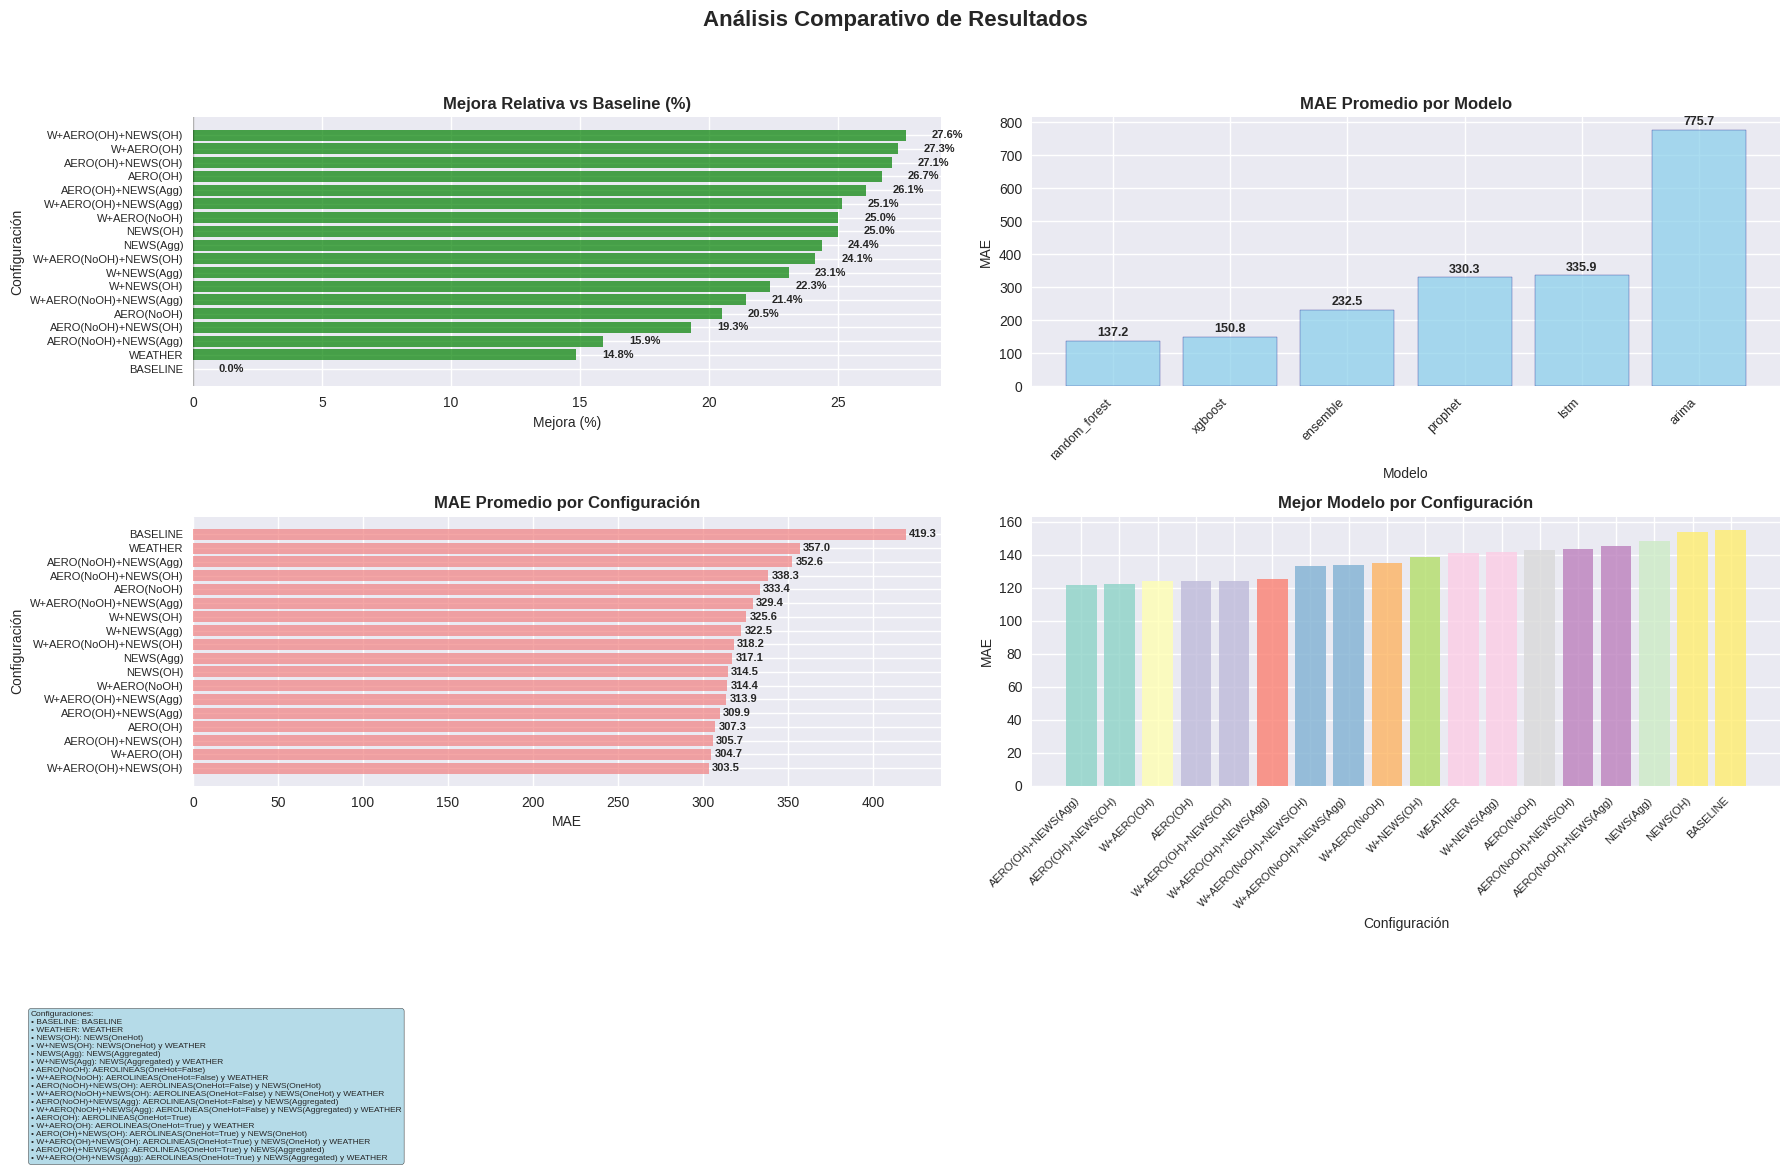

In [14]:
create_combined_plots(df_results)

---
## Análisis del mejor modelo global
---

In [8]:
def create_learning_curve_plot(json_file_path):
    """
    Crea una visualización de la curva de aprendizaje del mejor modelo usando datos reales.
    
    Args:
        json_file_path: Ruta al archivo JSON con resultados
    """
    try:
        # Cargar resultados
        with open(json_file_path, 'r', encoding='utf-8') as f:
            all_results = json.load(f)
        
        # Filtrar resultados exitosos y encontrar el mejor modelo
        successful_results = [r for r in all_results if r.get('best_model') != 'ERROR' and r.get('learning_curve') is not None]
        
        if not successful_results:
            print("❌ No hay resultados exitosos con curvas de aprendizaje para mostrar")
            return
        
        # Encontrar la mejor configuración (menor MAE)
        best_result = min(successful_results, key=lambda x: x['best_mae'])
        best_config = best_result['config']
        best_model_name = best_result['best_model']
        learning_curve_data = best_result['learning_curve']
        
        print(f"📈 Creando curva de aprendizaje real para el mejor modelo:")
        print(f"   Modelo: {best_model_name}")
        print(f"   Configuración: {best_config}")
        print(f"   MAE: {best_result['best_mae']:.2f}")
        
        # Crear figura para la curva de aprendizaje
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        
        # Extraer datos reales de la curva de aprendizaje
        # Convertir strings a arrays si es necesario
        train_sizes_str = learning_curve_data['train_sizes']
        train_scores_mean_str = learning_curve_data['train_scores_mean']
        train_scores_std_str = learning_curve_data['train_scores_std']
        val_scores_mean_str = learning_curve_data['val_scores_mean']
        val_scores_std_str = learning_curve_data['val_scores_std']
        
        # Convertir a arrays numéricos
        if isinstance(train_sizes_str, str):
            train_sizes = np.array([float(x) for x in train_sizes_str.strip('[]').split()])
            train_scores_mean = np.array([float(x) for x in train_scores_mean_str.strip('[]').split()])
            train_scores_std = np.array([float(x) for x in train_scores_std_str.strip('[]').split()])
            val_scores_mean = np.array([float(x) for x in val_scores_mean_str.strip('[]').split()])
            val_scores_std = np.array([float(x) for x in val_scores_std_str.strip('[]').split()])
        else:
            train_sizes = np.array(learning_curve_data['train_sizes'])
            train_scores_mean = np.array(learning_curve_data['train_scores_mean'])
            train_scores_std = np.array(learning_curve_data['train_scores_std'])
            val_scores_mean = np.array(learning_curve_data['val_scores_mean'])
            val_scores_std = np.array(learning_curve_data['val_scores_std'])
        
        # Graficar curvas con datos reales
        ax.plot(train_sizes, train_scores_mean, 'o-', color='#1f77b4', linewidth=2, markersize=6, label='MAE Entrenamiento')
        ax.fill_between(train_sizes, 
                        train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std,
                        alpha=0.2, color='#1f77b4')
        
        ax.plot(train_sizes, val_scores_mean, 's-', color='#ff7f0e', linewidth=2, markersize=6, label='MAE Validación')
        ax.fill_between(train_sizes,
                        val_scores_mean - val_scores_std,
                        val_scores_mean + val_scores_std,
                        alpha=0.2, color='#ff7f0e')
        
        # Añadir etiquetas con valores exactos en puntos clave
        for i, (x, y_train, y_val) in enumerate(zip(train_sizes[::2], train_scores_mean[::2], val_scores_mean[::2])):
            ax.annotate(f'{y_train:.1f}', (x, y_train), textcoords="offset points", 
                       xytext=(0,10), ha='center', fontsize=8, color='#1f77b4')
            ax.annotate(f'{y_val:.1f}', (x, y_val), textcoords="offset points", 
                       xytext=(0,-15), ha='center', fontsize=8, color='#ff7f0e')
        
        # Línea horizontal para el mejor MAE alcanzado
        final_mae = best_result['best_mae']
        ax.axhline(y=final_mae, color='red', linestyle='--', alpha=0.7, label=f'Mejor MAE: {final_mae:.2f}')
        
        # Configurar el gráfico
        ax.set_xlabel('Tamaño del conjunto de entrenamiento', fontsize=12, fontweight='bold')
        ax.set_ylabel('MAE', fontsize=12, fontweight='bold')
        ax.set_title(f'Curva de Aprendizaje Real - Mejor Modelo\n{best_model_name.upper()} ({best_config})', 
                    fontsize=14, fontweight='bold', pad=20)
        
        ax.set_yscale('log')
        
        # Configurar más marcas en el eje Y para mejor legibilidad
        y_min = min(np.min(train_scores_mean), np.min(val_scores_mean)) * 0.8
        y_max = max(np.max(train_scores_mean), np.max(val_scores_mean)) * 1.2
        
        # Crear marcas más densas en el eje Y
        y_ticks = np.logspace(np.log10(y_min), np.log10(y_max), 10)
        ax.set_yticks(y_ticks)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0f}" if y >= 1 else f"{y:.1f}"))
        ax.grid(True, alpha=0.3, which='both')
        ax.legend(fontsize=11, loc='upper right')
        
        # Añadir anotaciones importantes
        ax.annotate(f'Mejor rendimiento\nMAE: {final_mae:.2f}', 
                   xy=(train_sizes[-1], final_mae), xytext=(train_sizes[-1]*0.7, final_mae * 1.5),
                   arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                   fontsize=10, ha='center',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        # Añadir información sobre el sobreajuste
        final_train_mae = train_scores_mean[-1]
        final_val_mae = val_scores_mean[-1]
        
        # Asegurarse de que los valores sean numéricos
        try:
            final_train_mae = float(final_train_mae)
            final_val_mae = float(final_val_mae)
            overfitting_ratio = final_val_mae / final_train_mae if final_train_mae > 0 else float('inf')
        except (ValueError, TypeError):
            print("⚠️ No se pudo calcular el ratio de sobreajuste")
            overfitting_ratio = 1.0
        
        ax.text(0.02, 0.98, f'Ratio Validación/Entrenamiento: {overfitting_ratio:.2f}', 
               transform=ax.transAxes, fontsize=10,
               verticalalignment='top',
               bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen" if overfitting_ratio < 1.2 else "lightyellow", alpha=0.8))
        
        plt.tight_layout()
           
        plt.show()
        
    except Exception as e:
        print(f"❌ Error creando curva de aprendizaje: {e}")


In [9]:
def load_data_from_config(config, config_name, result_data):
    """Carga datos según la configuración especificada."""
    from models import ATCAircraftDataLoader, NewsDataLoader, WeatherDataLoader
    import pandas as pd
    
    data_loader = ATCAircraftDataLoader(config)
    df = data_loader.load_daily_atc_data()
    
    # Cargar datos ACIDS si corresponde
    acids_param = result_data.get('acids_param')
    if acids_param is not None:
        acids = data_loader.load_daily_acids_data(use_one_hot=acids_param)
        df = pd.merge(df, acids, left_index=True, right_index=True, how='left')
    
    # Cargar datos de noticias si corresponde
    news_param = result_data.get('news_param')
    if news_param is not None:
        news_loader = NewsDataLoader(config)
        if news_param == "one_hot":
            news = news_loader.load_news_events(feature_type="one_hot")
        else:  # aggregated
            news = news_loader.load_news_events(feature_type="aggregated")
        df = pd.merge(df, news, left_index=True, right_index=True, how='left')
    
    # Cargar datos meteorológicos si corresponde
    weather_param = result_data.get('weather_param', False)
    if weather_param:
        weather_loader = WeatherDataLoader(config)
        weather = weather_loader.load_weather_data()
        df = pd.merge(df, weather, left_index=True, right_index=True, how='left')
    
    return df

def create_single_model(config, model_name):
    """Crea una instancia del modelo especificado."""
    if model_name == "arima":
        return ARIMAModel(config)
    elif model_name == "prophet":
        return ProphetModel(config)
    elif model_name == "random_forest":
        return RandomForestModel(config)
    elif model_name == "xgboost":
        return XGBoostModel(config)
    elif model_name == "lstm":
        return LSTMModel(config)
    elif model_name == "ensemble":
        return EnsembleModel(config)
    else:
        raise ValueError(f"Modelo no reconocido: {model_name}")

In [10]:
def plot_model_analysis_dashboard(json_file_path, output_dir="train_results"):
    """
    Crea un dashboard completo con múltiples análisis del mejor modelo.
    
    Args:
        json_file_path: Ruta al archivo JSON con resultados
        output_dir: Directorio donde guardar los gráficos
    """
    try:
        # Cargar resultados y encontrar el mejor modelo
        with open(json_file_path, 'r', encoding='utf-8') as f:
            all_results = json.load(f)
        
        successful_results = [r for r in all_results if r.get('best_model') != 'ERROR']
        best_result = min(successful_results, key=lambda x: x['best_mae'])
        
        best_config_name = best_result['config']
        best_model_name = best_result['best_model']
        best_mae = best_result['best_mae']
        
        print(f"📊 Creando dashboard para el mejor modelo:")
        print(f"   Modelo: {best_model_name}")
        print(f"   Configuración: {best_config_name}")
        
        # Preparar datos (reutilizar función existente)
        config = ModelConfig()
        df = load_data_from_config(config, best_config_name, best_result)
        
        preprocessor = AircraftDataPreprocessor(config)
        df_processed = preprocessor.preprocess_daily_data(df)
        
        feature_engineer = AircraftFeatureEngineer(config)
        df_featured = feature_engineer.create_features(df_processed)
        df_featured = feature_engineer.create_lagged_target(df_featured, 1)
        
        X, y = feature_engineer.select_features_for_model(df_featured)
        
        # Dividir datos
        train_size = int(len(X) * 0.8)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
        
        # Entrenar modelo
        model = create_single_model(config, best_model_name)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        dates = df_featured.index[train_size:]
        
        # Crear dashboard con 4 gráficos
        fig, axes = plt.subplots(2, 2, figsize=(20, 12))
        fig.suptitle(f'Dashboard del Mejor Modelo - {best_model_name.upper()}\\n{best_config_name}', 
                     fontsize=16, fontweight='bold')
        
        # 1. Predicciones vs Reales (gráfico principal)
        ax1 = axes[0, 0]
        ax1.plot(dates, y_test, label='Valor Real', color='blue', linewidth=2, alpha=0.8)
        ax1.plot(dates, y_pred, label=f'Predicción ({best_model_name.upper()})',
                color='red', linestyle='--', linewidth=2, alpha=0.8)
        ax1.set_title('Predicciones vs Valores Reales', fontweight='bold')
        ax1.set_xlabel('Fecha')
        ax1.set_ylabel('Número de Aeronaves')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45)
        
        # 2. Residuos (errores)
        ax2 = axes[0, 1]
        residuals = y_test - y_pred
        ax2.scatter(y_pred, residuals, alpha=0.6, color='purple')
        ax2.axhline(y=0, color='red', linestyle='--', alpha=0.8)
        ax2.set_title('Análisis de Residuos', fontweight='bold')
        ax2.set_xlabel('Predicciones')
        ax2.set_ylabel('Residuos (Real - Predicho)')
        ax2.grid(True, alpha=0.3)
        
        # Añadir línea de tendencia
        z = np.polyfit(y_pred, residuals, 1)
        p = np.poly1d(z)
        ax2.plot(y_pred, p(y_pred), "r--", alpha=0.8, label=f'Tendencia: y={z[0]:.3f}x+{z[1]:.1f}')
        ax2.legend()
        
        # 3. Distribución de Errores
        ax3 = axes[1, 0]
        mae_values = np.abs(residuals)
        mae = np.mean(mae_values)  # Calculate MAE from residuals
        ax3.hist(mae_values, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        ax3.axvline(x=mae, color='red', linestyle='--', linewidth=2, label=f'MAE: {mae:.2f}')
        ax3.set_title('Distribución de Errores Absolutos', fontweight='bold')
        ax3.set_xlabel('Error Absoluto')
        ax3.set_ylabel('Frecuencia')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. Scatter Plot: Predicciones vs Reales con línea de identidad
        ax4 = axes[1, 1]
        ax4.scatter(y_test, y_pred, alpha=0.6, color='green')
        
        # Línea y=x (predicción perfecta)
        min_val = min(y_test.min(), y_pred.min())
        max_val = max(y_test.max(), y_pred.max())
        ax4.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Predicción Perfecta')
        
        # Calcular R²
        r2 = r2_score(y_test, y_pred)
        ax4.set_title(f'Predicciones vs Reales (R² = {r2:.3f})', fontweight='bold')
        ax4.set_xlabel('Valores Reales')
        ax4.set_ylabel('Predicciones')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        # Ajustar layout
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # # Guardar dashboard
        # Path(output_dir).mkdir(parents=True, exist_ok=True)
        # safe_config = best_config_name.replace(" ", "_").replace("(", "").replace(")", "").replace(":", "_")
        # dashboard_path = Path(output_dir) / f'model_dashboard_{best_model_name}_{safe_config}.png'
        # plt.savefig(dashboard_path, dpi=300, bbox_inches='tight')
        # print(f"📊 Dashboard guardado en: {dashboard_path}")
        
        # plt.show()
        
        # Crear segundo dashboard con análisis de importancia de features (si el modelo lo permite)
        # if hasattr(model, 'feature_importances_') or best_model_name in ['random_forest', 'xgboost']:
        #     plot_feature_importance(model, X_train, best_model_name, best_config_name, output_dir)
        
    except Exception as e:
        print(f"❌ Error creando dashboard: {e}")
        import traceback
        traceback.print_exc()
        return None

def plot_feature_importance(model, X_train, model_name, config_name, output_dir="train_results"):
    """
    Crea gráfico de importancia de features para modelos que lo soportan.
    """
    try:
        fig, ax = plt.subplots(figsize=(12, 8))
        
        if hasattr(model, 'feature_importances_'):
            # Para RandomForest, XGBoost, etc.
            importances = model.feature_importances_
            feature_names = X_train.columns
            
            # Ordenar por importancia
            indices = np.argsort(importances)[::-1]
            top_n = min(20, len(importances))  # Top 20 features
            
            ax.bar(range(top_n), importances[indices[:top_n]], color='skyblue', alpha=0.8)
            ax.set_title(f'Top {top_n} Features más Importantes - {model_name.upper()}', fontweight='bold')
            ax.set_xlabel('Features')
            ax.set_ylabel('Importancia')
            
            # Configurar etiquetas
            ax.set_xticks(range(top_n))
            feature_labels = [feature_names[i] if len(feature_names[i]) <= 15 
                           else feature_names[i][:12] + '...' 
                           for i in indices[:top_n]]
            ax.set_xticklabels(feature_labels, rotation=45, ha='right')
            
            # Añadir valores
            for i, v in enumerate(importances[indices[:top_n]]):
                ax.text(i, v + max(importances) * 0.01, f'{v:.3f}', 
                       ha='center', va='bottom', fontsize=8)
        
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        
        # # Guardar gráfico
        # safe_config = config_name.replace(" ", "_").replace("(", "").replace(")", "").replace(":", "_")
        # importance_path = Path(output_dir) / f'feature_importance_{model_name}_{safe_config}.png'
        # plt.savefig(importance_path, dpi=300, bbox_inches='tight')
        # print(f"📈 Importancia de features guardada en: {importance_path}")
        
        plt.show()
        
    except Exception as e:
        print(f"⚠️ No se pudo crear gráfico de importancia de features: {e}")
      

In [21]:
def plot_residuals_analysis(json_file_path, output_dir="train_results"):
    """
    Crea un análisis detallado de residuos para el mejor modelo.
    
    Args:
        json_file_path: Ruta al archivo JSON con resultados
        output_dir: Directorio donde guardar los gráficos
    """
    try:
        # Cargar resultados y encontrar el mejor modelo
        with open(json_file_path, 'r', encoding='utf-8') as f:
            all_results = json.load(f)
        
        successful_results = [r for r in all_results if r.get('best_model') != 'ERROR']
        best_result = min(successful_results, key=lambda x: x['best_mae'])
        
        best_config_name = best_result['config']
        best_model_name = best_result['best_model']
        best_mae = best_result['best_mae']
        
        print(f"🔍 Analizando residuos del mejor modelo:")
        print(f"   Modelo: {best_model_name}")
        print(f"   Configuración: {best_config_name}")
        
        # Preparar datos
        config = ModelConfig()
        df = load_data_from_config(config, best_config_name, best_result)
        
        preprocessor = AircraftDataPreprocessor(config)
        df_processed = preprocessor.preprocess_daily_data(df)
        
        feature_engineer = AircraftFeatureEngineer(config)
        df_featured = feature_engineer.create_features(df_processed)
        df_featured = feature_engineer.create_lagged_target(df_featured, 1)
        
        X, y = feature_engineer.select_features_for_model(df_featured)
        
        # Dividir datos
        train_size = int(len(X) * 0.8)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
        
        # Entrenar modelo
        model = create_single_model(config, best_model_name)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        dates = df_featured.index[train_size:]
        residuals = y_test - y_pred
        
        # Crear figura con múltiples análisis de residuos
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle(f'Análisis Detallado de Residuos - {best_model_name.upper()}\\n{best_config_name}', 
                     fontsize=16, fontweight='bold')
        
        # 1. Residuos vs Predicciones
        ax1 = axes[0, 0]
        ax1.scatter(y_pred, residuals, alpha=0.6, color='purple')
        ax1.axhline(y=0, color='red', linestyle='--', alpha=0.8)
        ax1.set_title('Residuos vs Predicciones', fontweight='bold')
        ax1.set_xlabel('Predicciones')
        ax1.set_ylabel('Residuos')
        ax1.grid(True, alpha=0.3)
        
        # Añadir línea de tendencia
        z = np.polyfit(y_pred, residuals, 1)
        p = np.poly1d(z)
        ax1.plot(y_pred, p(y_pred), "r--", alpha=0.8, label=f'Tendencia: y={z[0]:.3f}x+{z[1]:.1f}')
        ax1.legend()
        
        # 2. Histograma de Residuos
        ax2 = axes[0, 1]
        ax2.hist(residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        ax2.axvline(x=0, color='red', linestyle='--', linewidth=2)
        ax2.set_title('Distribución de Residuos', fontweight='bold')
        ax2.set_xlabel('Residuos')
        ax2.set_ylabel('Frecuencia')
        ax2.grid(True, alpha=0.3)
        
        # Añadir estadísticas
        mean_residual = np.mean(residuals)
        std_residual = np.std(residuals)
        ax2.text(0.02, 0.98, f'Media: {mean_residual:.2f}\\nStd: {std_residual:.2f}', 
                transform=ax2.transAxes, fontsize=10,
                verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        # 3. Q-Q Plot
        ax3 = axes[0, 2]
        from scipy import stats
        stats.probplot(residuals, dist="norm", plot=ax3)
        ax3.set_title('Q-Q Plot (Normalidad)', fontweight='bold')
        ax3.grid(True, alpha=0.3)
        
        # 4. Residuos vs Tiempo
        ax4 = axes[1, 0]
        ax4.plot(dates, residuals, alpha=0.7, color='green')
        ax4.axhline(y=0, color='red', linestyle='--', alpha=0.8)
        ax4.set_title('Residuos vs Tiempo', fontweight='bold')
        ax4.set_xlabel('Fecha')
        ax4.set_ylabel('Residuos')
        ax4.grid(True, alpha=0.3)
        ax4.tick_params(axis='x', rotation=45)
        
        # 5. Residuos Absolutos vs Predicciones
        ax5 = axes[1, 1]
        abs_residuals = np.abs(residuals)
        ax5.scatter(y_pred, abs_residuals, alpha=0.6, color='orange')
        ax5.set_title('Residuos Absolutos vs Predicciones', fontweight='bold')
        ax5.set_xlabel('Predicciones')
        ax5.set_ylabel('Residuos Absolutos')
        ax5.grid(True, alpha=0.3)
        
        # Añadir línea de tendencia para heterocedasticidad
        z_abs = np.polyfit(y_pred, abs_residuals, 1)
        p_abs = np.poly1d(z_abs)
        ax5.plot(y_pred, p_abs(y_pred), "r--", alpha=0.8, label=f'Tendencia: y={z_abs[0]:.3f}x+{z_abs[1]:.1f}')
        ax5.legend()
        
        # 6. Autocorrelación de Residuos
        ax6 = axes[1, 2]
        from statsmodels.tsa.stattools import acf
        try:
            acf_values = acf(residuals, nlags=20, fft=True)
            lags = range(len(acf_values))
            ax6.bar(lags, acf_values, alpha=0.7, color='lightcoral')
            ax6.axhline(y=0, color='black', linestyle='-', alpha=0.3)
            ax6.axhline(y=0.05, color='red', linestyle='--', alpha=0.5, label='Límite 5%')
            ax6.axhline(y=-0.05, color='red', linestyle='--', alpha=0.5)
            ax6.set_title('Autocorrelación de Residuos', fontweight='bold')
            ax6.set_xlabel('Lag')
            ax6.set_ylabel('Autocorrelación')
            ax6.grid(True, alpha=0.3)
            ax6.legend()
        except Exception as e:
            ax6.text(0.5, 0.5, f'No se pudo calcular\\nautocorrelación:\\n{str(e)[:50]}...', 
                    transform=ax6.transAxes, fontsize=10,
                    horizontalalignment='center', verticalalignment='center')
            ax6.set_title('Autocorrelación - Error', fontweight='bold')
        
        # Ajustar layout
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Guardar gráfico
        Path(output_dir).mkdir(parents=True, exist_ok=True)
        safe_config = best_config_name.replace(" ", "_").replace("(", "").replace(")", "").replace(":", "_")
        residuals_path = Path(output_dir) / f'residuals_analysis_{best_model_name}_{safe_config}.png'
        plt.savefig(residuals_path, dpi=300, bbox_inches='tight')
        print(f"📊 Análisis de residuos guardado en: {residuals_path}")
        
        plt.show()
        
        # Imprimir estadísticas adicionales
        print("\\n📈 Estadísticas de Residuos:")
        print(f"   Media: {mean_residual:.4f}")
        print(f"   Desviación estándar: {std_residual:.4f}")
        print(f"   MAE: {np.mean(abs_residuals):.4f}")
        print(f"   RMSE: {np.sqrt(np.mean(residuals**2)):.4f}")
        
        # Test de normalidad
        try:
            from scipy.stats import shapiro, jarque_bera
            shapiro_stat, shapiro_p = shapiro(residuals[:5000])  # Limitar a 5000 muestras
            jb_stat, jb_p = jarque_bera(residuals)
            
            print("\\n🧪 Tests de Normalidad:")
            print(f"   Shapiro-Wilk: estadístico={shapiro_stat:.4f}, p-valor={shapiro_p:.4f}")
            print(f"   Jarque-Bera: estadístico={jb_stat:.4f}, p-valor={jb_p:.4f}")
            
            if shapiro_p > 0.05:
                print("   ✅ Los residuos parecen normales (Shapiro-Wilk)")
            else:
                print("   ❌ Los residuos no parecen normales (Shapiro-Wilk)")
                
        except Exception as e:
            print(f"⚠️ No se pudieron realizar los tests de normalidad: {e}")
        
        return residuals_path
        
    except Exception as e:
        print(f"❌ Error en análisis de residuos: {e}")
        import traceback
        traceback.print_exc()
        return None

📈 Creando curva de aprendizaje real para el mejor modelo:
   Modelo: xgboost
   Configuración: AEROLINEAS(OneHot=True) y NEWS(Aggregated)
   MAE: 121.85


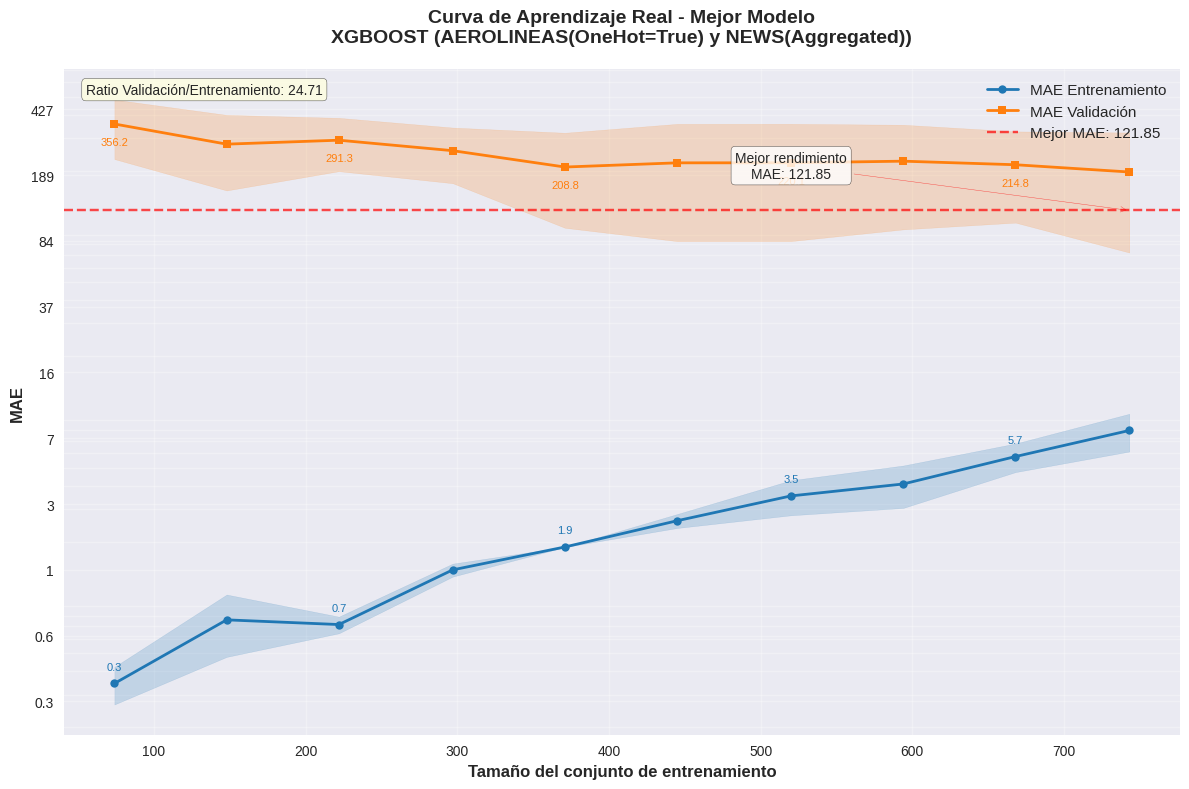

In [15]:
create_learning_curve_plot(json_file_path)

📊 Creando dashboard para el mejor modelo:
   Modelo: xgboost
   Configuración: AEROLINEAS(OneHot=True) y NEWS(Aggregated)


/home/gabo/Personal/Universidad/04 - Cuarto Año/1er Semestre/Machine Learning/Proyectos/ml-project/models/preprocessing.py:123: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_reindexed = df_reindexed.fillna(method='ffill').fillna(method='bfill')
/home/gabo/Personal/Universidad/04 - Cuarto Año/1er Semestre/Machine Learning/Proyectos/ml-project/models/features.py:304: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[recovery_mask, 'covid_impact'] = 0.5


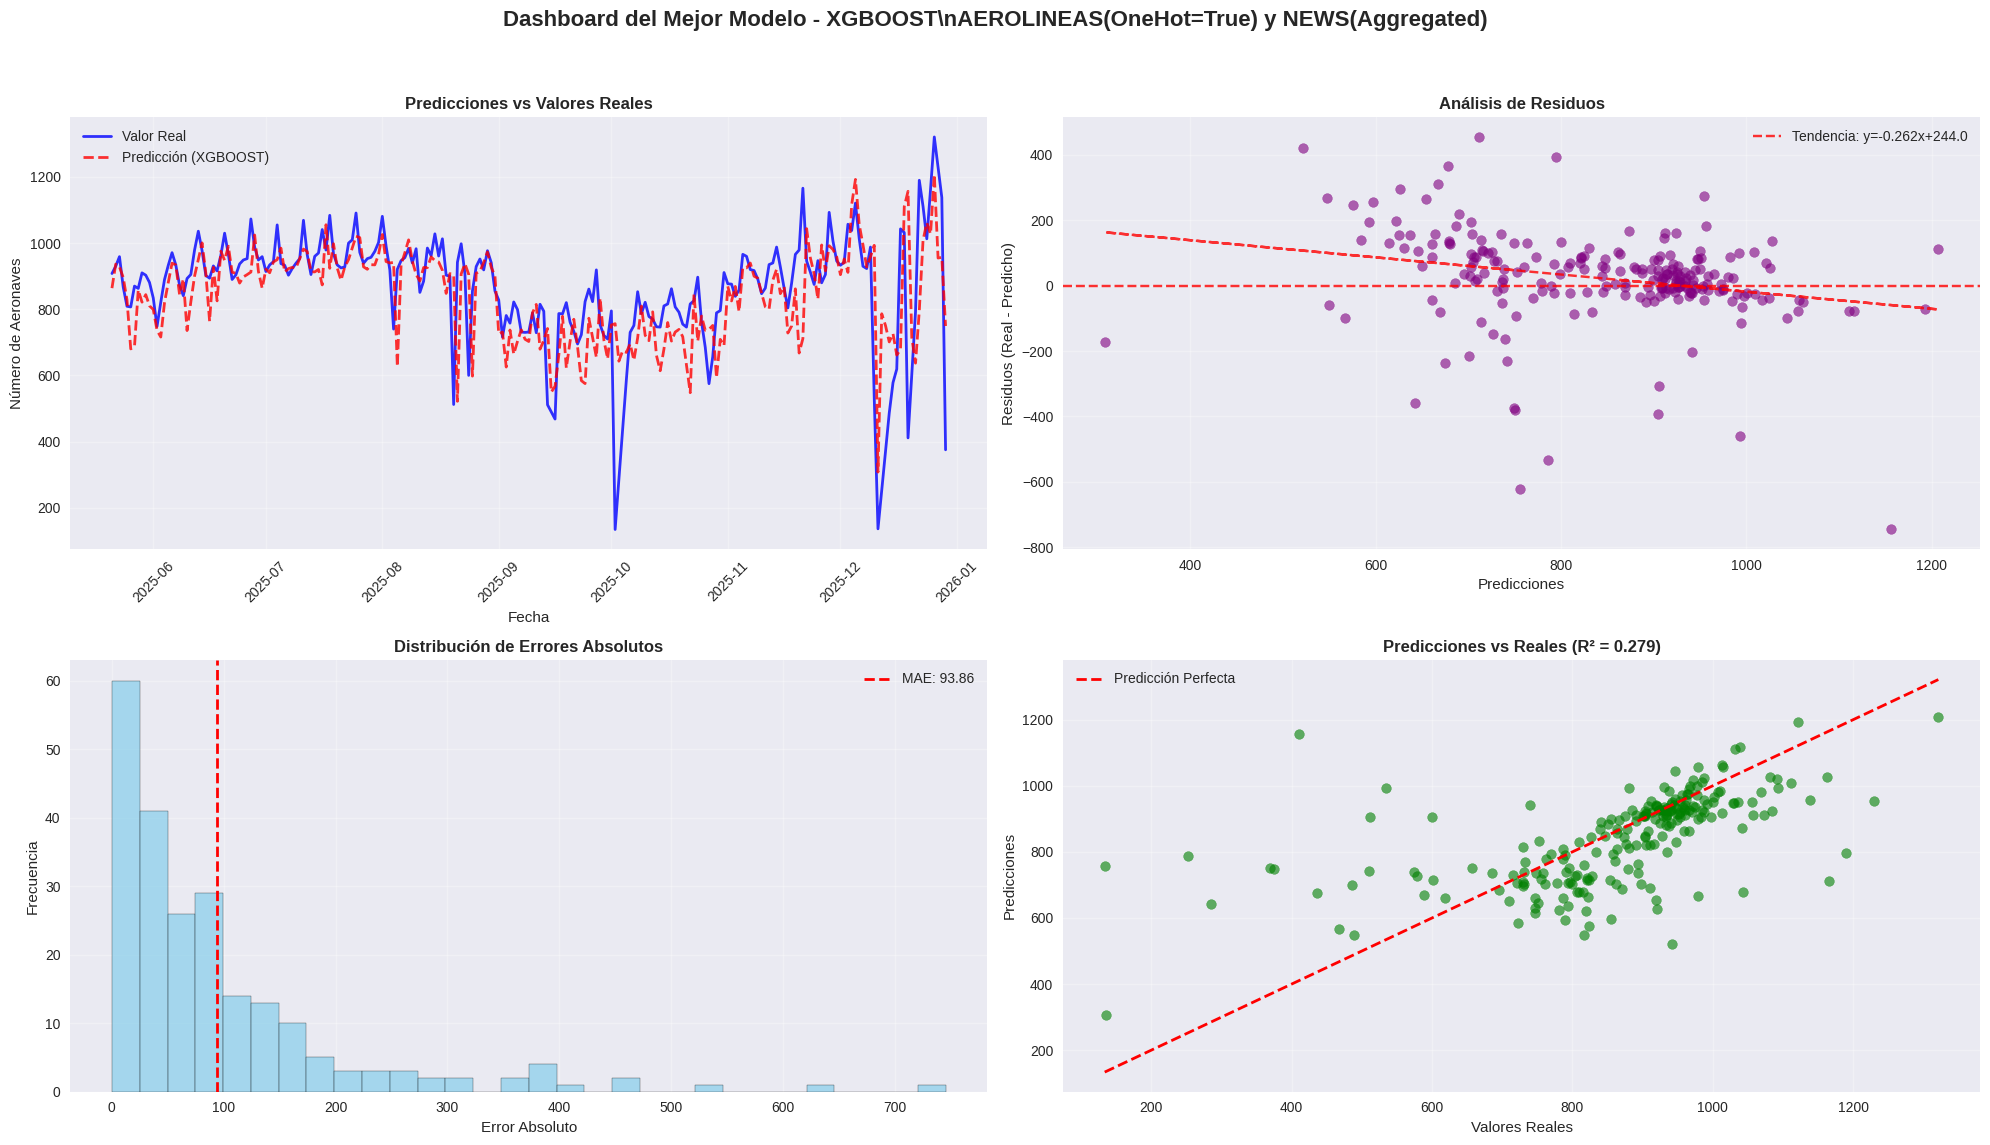

In [16]:
plot_model_analysis_dashboard(json_file_path)

🔍 Analizando residuos del mejor modelo:
   Modelo: xgboost
   Configuración: AEROLINEAS(OneHot=True) y NEWS(Aggregated)


/home/gabo/Personal/Universidad/04 - Cuarto Año/1er Semestre/Machine Learning/Proyectos/ml-project/models/preprocessing.py:123: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_reindexed = df_reindexed.fillna(method='ffill').fillna(method='bfill')
/home/gabo/Personal/Universidad/04 - Cuarto Año/1er Semestre/Machine Learning/Proyectos/ml-project/models/features.py:304: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[recovery_mask, 'covid_impact'] = 0.5


📊 Análisis de residuos guardado en: train_results/residuals_analysis_xgboost_AEROLINEASOneHot=True_y_NEWSAggregated.png


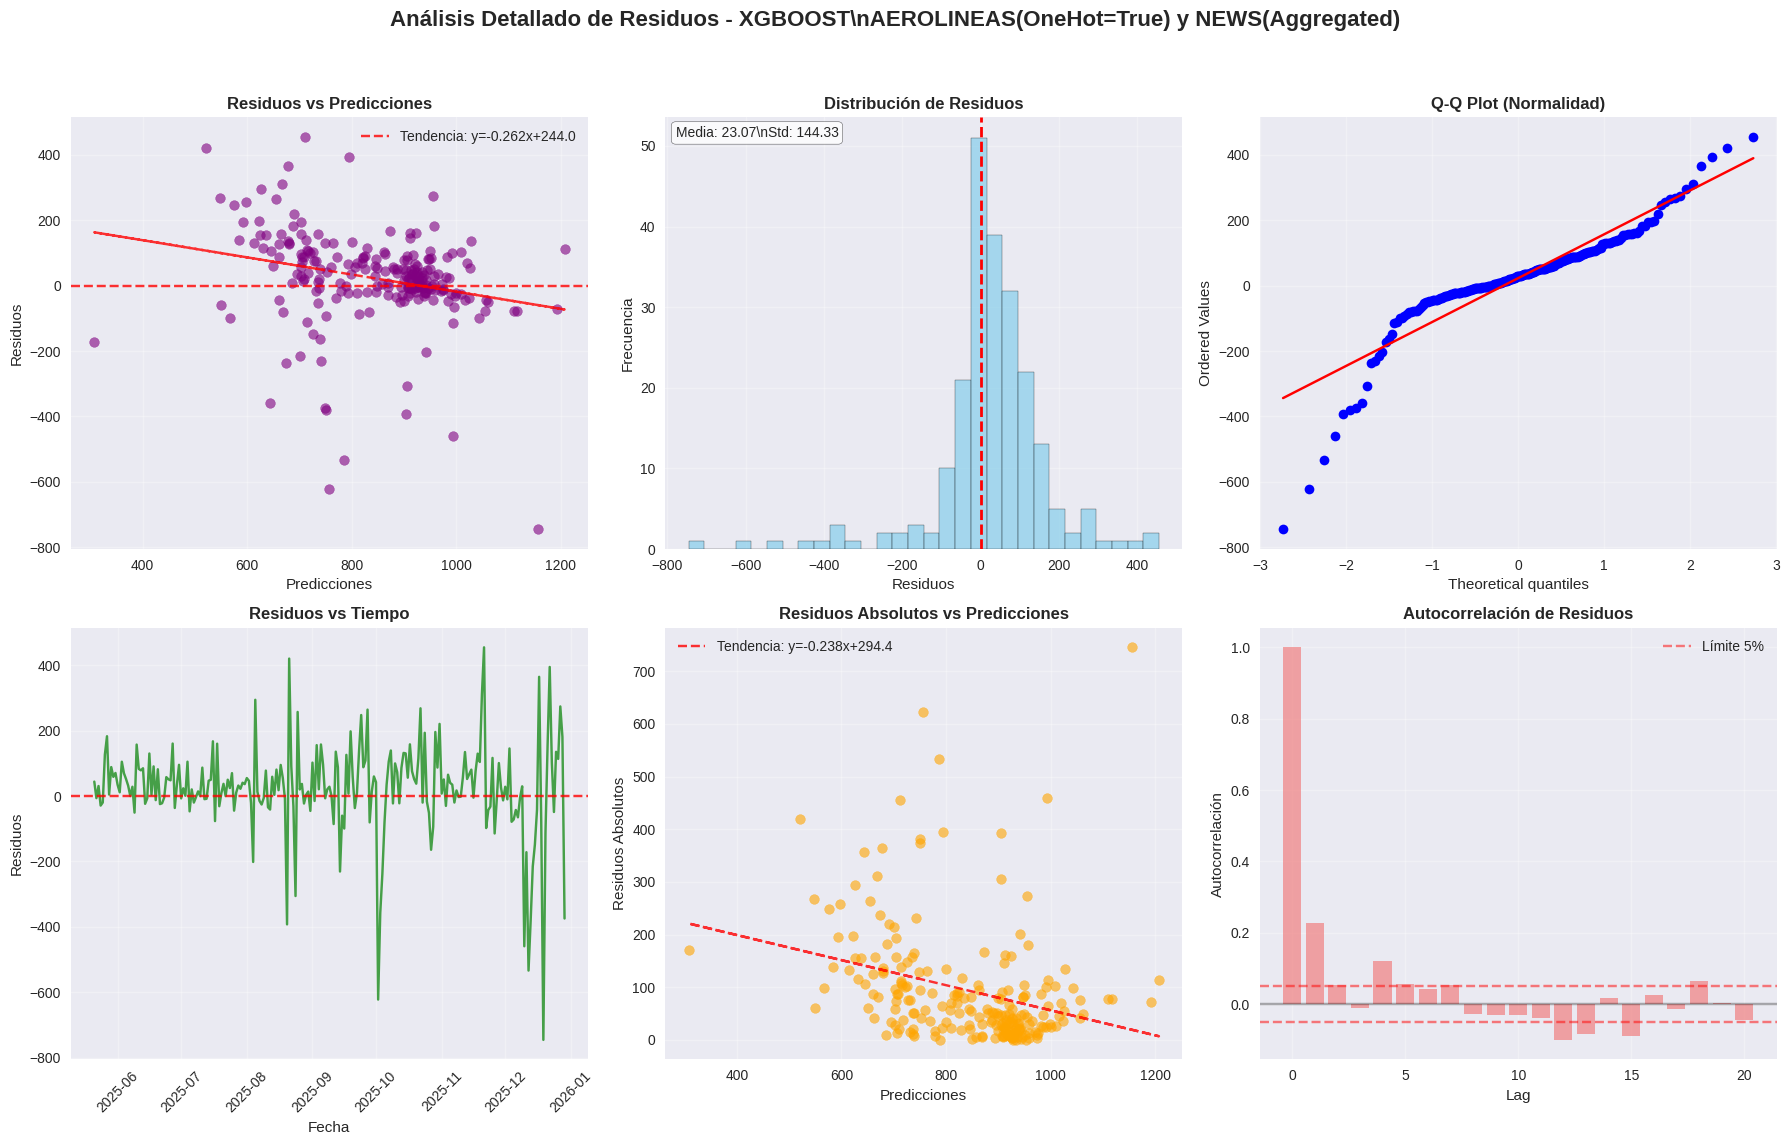

\n📈 Estadísticas de Residuos:
   Media: 23.0706
   Desviación estándar: 144.3280
   MAE: 93.8555
   RMSE: 146.1603
\n🧪 Tests de Normalidad:
   Shapiro-Wilk: estadístico=0.8525, p-valor=0.0000
   Jarque-Bera: estadístico=497.2464, p-valor=0.0000
   ❌ Los residuos no parecen normales (Shapiro-Wilk)


PosixPath('train_results/residuals_analysis_xgboost_AEROLINEASOneHot=True_y_NEWSAggregated.png')

In [20]:
plot_residuals_analysis(json_file_path)

---
## Análisis del Hyperparameter Tunning
---

In [37]:
def plot_optimization_summary(study):
    """Muestra un resumen visual estilizado de la optimización."""
    fig, axs = plt.subplots(2, 2, figsize=(18, 12), gridspec_kw={"height_ratios": [2, 1.4]})
    fig.suptitle('Resumen de la Optimización de Hiperparámetros', fontsize=20, weight='bold', y=0.98)

    trials_df = study.trials_dataframe().sort_values('number')
    completed = trials_df[trials_df['state'] == 'COMPLETE'].copy()
    best_trial = study.best_trial
    best_algorithm = best_trial.params.get('algorithm', 'N/D')

    # 1. Historial de optimización
    ax_hist = axs[0, 0]
    if not completed.empty:
        completed['mae'] = completed['value'].astype(float)
        completed['best_so_far'] = completed['mae'].cummin()

        sns.lineplot(data=completed, x='number', y='mae', ax=ax_hist, label='MAE por trial', linewidth=2)
        sns.lineplot(data=completed, x='number', y='best_so_far', ax=ax_hist,
                     label='Mejor MAE acumulado', linewidth=2.5, linestyle='--', color='#2ca02c')
        ax_hist.set_title('Historial de Optimización (todos los algoritmos)', weight='bold')
        ax_hist.set_xlabel('Número de trial')
        ax_hist.set_ylabel('MAE')
        ax_hist.set_yscale('log')
        ax_hist.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0f}"))
        ax_hist.legend(loc='upper right')
    else:
        ax_hist.text(0.5, 0.5, 'No hay trials completados', ha='center', va='center')

    # 2. Importancia de parámetros
    ax_importance = axs[0, 1]
    best_algo = best_trial.params.get('algorithm')
    
    if best_algo is None:
        ax_importance.text(0.5, 0.5, 'No se pudo identificar el algoritmo ganador', ha='center', va='center')
    else:
        # Usar la función de importancia pasando el eje existente
        plot_hyperparameter_importance(study, ax=ax_importance)
        ax_importance.set_title(f'Importancia de Hiperparámetros\n({best_algo})', weight='bold')

    # 3. Mejores parámetros en formato tabla
    ax_params = axs[1, 0]
    ax_params.axis('off')
    try:
        best_params = study.best_params
        rows = []
        if 'algorithm' in best_params:
            rows.append(['algorithm', f"{best_algorithm}"])
        rows.extend([[k, f"{v}"] for k, v in best_params.items() if k != 'algorithm'])
        table = ax_params.table(cellText=rows, colLabels=['Parámetro', 'Valor'], loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1.2, 1.4)
        ax_params.set_title('Mejores Parámetros', weight='bold', pad=20)
    except Exception:
        ax_params.text(0.5, 0.5, 'No se pudieron obtener los mejores parámetros', ha='center', va='center')

    # 4. Distribución de valores
    ax_dist = axs[1, 1]
    if not completed.empty:
        sns.histplot(data=completed, x='mae', bins=20, kde=True, ax=ax_dist, color='#1f77b4')
        ax_dist.set_title('Distribución del MAE (todos los algoritmos)', weight='bold')
        ax_dist.set_xlabel('MAE')
        ax_dist.set_ylabel('Frecuencia')
        ax_dist.set_yscale('log')
        ax_dist.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0f}"))
    else:
        ax_dist.text(0.5, 0.5, 'Sin datos suficientes para el histograma', ha='center', va='center')

    fig.text(
        0.5,
        0.015,
        'El historial y la distribución combinan todos los algoritmos evaluados. La tabla y los gráficos de '
        f'importancia/relaciones se centran en el mejor modelo encontrado: {best_algorithm}.',
        ha='center',
        fontsize=11
    )
    plt.tight_layout(rect=[0, 0.05, 1, 0.97])


In [38]:
def plot_algorithm_comparison(study):
    """Compara el rendimiento de los algoritmos con métricas claras."""
    trials_df = study.trials_dataframe()
    if 'params_algorithm' not in trials_df.columns:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.text(0.5, 0.5, 'No se registró el parámetro "algorithm" en los trials', ha='center', va='center')
        return fig

    completed = trials_df[trials_df['state'] == 'COMPLETE'].copy()
    completed['mae'] = completed['value'].astype(float)
    completed['algorithm'] = completed['params_algorithm']

    if completed.empty:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.text(0.5, 0.5, 'No hay trials completados para comparar', ha='center', va='center')
        return fig

    summary = (completed.groupby('algorithm')['mae']
               .agg(['median', 'min', 'count'])
               .rename(columns={'median': 'MAE mediano', 'min': 'Mejor MAE', 'count': 'Trials'}))

    fig, axes = plt.subplots(1, 2, figsize=(18, 7), gridspec_kw={'width_ratios': [2, 1]})

    ax_box, ax_bar = axes
    sns.boxplot(data=completed, x='algorithm', y='mae', ax=ax_box, hue='algorithm', palette='viridis', legend=False)
    sns.stripplot(data=completed, x='algorithm', y='mae', ax=ax_box, color='black', size=5, alpha=0.6, jitter=True)
    ax_box.set_title('Distribución del MAE por Algoritmo', weight='bold')
    ax_box.set_xlabel('Algoritmo')
    ax_box.set_ylabel('MAE (escala log)')
    ax_box.set_yscale('log')
    ax_box.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0f}"))
    ax_box.axhline(summary['Mejor MAE'].min(), color='red', linestyle='--', linewidth=1.5, label='Mejor MAE global')
    ax_box.legend(loc='upper right')

    summary_sorted = summary.sort_values('Mejor MAE')
    summary_sorted['Algorithm'] = summary_sorted.index
    sns.barplot(data=summary_sorted, y='Algorithm', x='Mejor MAE', ax=ax_bar, palette='mako')
    for i, (mae, count) in enumerate(zip(summary_sorted['Mejor MAE'], summary_sorted['Trials'])):
        ax_bar.text(mae, i, f"{mae:.2f}\n({count} trials)", va='center', ha='left', fontsize=11)
    ax_bar.set_title('Mejor MAE por Algoritmo', weight='bold')
    ax_bar.set_xlabel('Mejor MAE')
    ax_bar.set_ylabel('')
    ax_bar.set_xscale('log')
    ax_bar.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0f}"))

    plt.tight_layout()

In [39]:
def plot_hyperparameter_importance(study, ax=None):
    """Muestra la importancia de los hiperparámetros con anotaciones."""
    create_fig = ax is None
    if create_fig:
        fig, ax = plt.subplots(figsize=(12, 7))
    
    best_trial = study.best_trial
    best_algo = best_trial.params.get('algorithm')

    trials_df = study.trials_dataframe()
    completed = trials_df[trials_df['state'] == 'COMPLETE'].copy()

    if best_algo is None:
        ax.text(0.5, 0.5, 'El parámetro "algorithm" no está disponible en el mejor trial', 
               ha='center', va='center')
        return fig if create_fig else None

    algo_trials = completed[completed['params_algorithm'] == best_algo].copy()
    if len(algo_trials) < 3:
        ax.text(0.5, 0.5, f'No hay suficientes trials para {best_algo}', 
               ha='center', va='center')
        return fig if create_fig else None

    algo_trials['mae'] = algo_trials['value'].astype(float)

    param_cols = [
        col for col in algo_trials.columns
        if col.startswith('params_')
        and col != 'params_algorithm'
        and algo_trials[col].notna().any()
    ]
    
    if not param_cols:
        ax.text(0.5, 0.5, f'{best_algo} no aporta hiperparámetros adicionales', 
               ha='center', va='center')
        return fig if create_fig else None

    def _encode_series(series: pd.Series) -> pd.Series:
        if pd.api.types.is_bool_dtype(series):
            return series.astype(int)
        if pd.api.types.is_numeric_dtype(series):
            return series.astype(float)
        return series.astype(str).astype('category').cat.codes.astype(float)

    importances = {}
    for col in param_cols:
        encoded = _encode_series(algo_trials[col])
        if encoded.dropna().nunique() <= 1:
            continue
        corr = encoded.corr(algo_trials['mae'], method='spearman')
        if pd.notnull(corr):
            importances[col] = abs(corr)

    if not importances:
        ax.text(0.5, 0.5, 
               f'Hiperparámetros de {best_algo} sin variación suficiente para calcular importancia',
               ha='center', va='center')
        return fig if create_fig else None

    importance_df = (pd.DataFrame({
        'Parámetro': [p.replace('params_', '').replace('_', ' ').title() for p in importances.keys()],
        'Importancia': list(importances.values())
    })
    .loc[lambda df: df['Importancia'] > 0]
    .sort_values('Importancia', ascending=True))

    total = importance_df['Importancia'].sum()
    if total == 0:
        ax.text(0.5, 0.5,
               f'No se detectó relación monotónica clara entre los hiperparámetros de {best_algo} y el MAE',
               ha='center', va='center')
        return fig if create_fig else None

    importance_df['Importancia (%)'] = 100 * importance_df['Importancia'] / total

    # Limpiar el eje antes de dibujar
    ax.clear()
    
    # Crear el gráfico de barras con hue para evitar la advertencia
    sns.barplot(data=importance_df, x='Importancia (%)', y='Parámetro', 
                hue='Parámetro', legend=False, ax=ax, palette='crest')
    
    # Añadir las etiquetas de porcentaje
    for i, pct in enumerate(importance_df['Importancia (%)']):
        ax.text(pct + 1, i, f"{pct:.1f}%", va='center', fontsize=11)

    ax.set_title(f'Importancia de Hiperparámetros para {best_algo}', weight='bold')
    ax.set_xlabel('Contribución relativa (Spearman |ρ|)')
    ax.set_ylabel('Parámetro')
    
    if create_fig:
        plt.tight_layout()



In [40]:
def plot_hyperparameter_relationships(study):
    """Explora la relación entre los hiperparámetros numéricos y el MAE."""
    trials_df = study.trials_dataframe()
    completed = trials_df[trials_df['state'] == 'COMPLETE'].copy()

    best_algo = study.best_trial.params.get('algorithm')
    if best_algo is None:
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.text(0.5, 0.5, 'No se pudo identificar el algoritmo ganador', ha='center', va='center')
        return fig

    algo_trials = completed[completed['params_algorithm'] == best_algo].copy()
    if len(algo_trials) < 3:
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.text(0.5, 0.5, f'Se necesitan más trials para {best_algo}', ha='center', va='center')
        return fig

    algo_trials['mae'] = algo_trials['value'].astype(float)

    def _encode_series(series: pd.Series) -> pd.Series:
        if pd.api.types.is_bool_dtype(series):
            return series.astype(int)
        if pd.api.types.is_numeric_dtype(series):
            return series.astype(float)
        return series.astype(str).astype('category').cat.codes.astype(float)

    param_cols = [
        col for col in algo_trials.columns
        if col.startswith('params_')
        and col != 'params_algorithm'
        and algo_trials[col].notna().any()
    ]
    if not param_cols:
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.text(0.5, 0.5, f'{best_algo} no cuenta con hiperparámetros numéricos', ha='center', va='center')
        return fig

    encoded_df = {}
    for col in param_cols:
        encoded = _encode_series(algo_trials[col])
        if encoded.dropna().nunique() <= 1:
            continue
        encoded_df[col] = encoded

    if not encoded_df:
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.text(0.5, 0.5, f'Hiperparámetros de {best_algo} sin variación suficiente', ha='center', va='center')
        return fig

    encoded_df = pd.DataFrame(encoded_df)
    encoded_df['mae'] = algo_trials['mae'].values

    params = list(encoded_df.columns)
    params.remove('mae')
    n_params = len(params)
    n_cols = 2
    n_rows = int(np.ceil(n_params / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows), squeeze=False)

    for idx, param in enumerate(params):
        row, col = divmod(idx, n_cols)
        ax = axes[row][col]
        sns.scatterplot(data=encoded_df, x=param, y='mae', ax=ax, alpha=0.8, s=60)
        sns.regplot(data=encoded_df, x=param, y='mae', scatter=False, ax=ax, color='black', line_kws={'lw': 2})
        ax.set_title(f'{param.replace("params_", "").replace("_", " ").title()} vs MAE', weight='bold')
        ax.set_xlabel(param.replace('params_', '').replace('_', ' ').title())
        ax.set_ylabel('MAE (log)')
        ax.set_yscale('log')
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0f}"))

    for idx in range(n_params, n_rows * n_cols):
        row, col = divmod(idx, n_cols)
        axes[row][col].axis('off')

    fig.suptitle(f'Relaciones entre Hiperparámetros y MAE para {best_algo}', fontsize=20, weight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])


In [63]:
def load_and_prepare_data(forecast_horizon=1):
    """Carga y prepara los datos para el entrenamiento."""
    # Configuración
    config = ModelConfig()
    RANDOM_STATE = 42
        
    # 1. Cargar datos
    data_loader = ATCAircraftDataLoader(config)
    df = data_loader.load_daily_atc_data()
    
    acids = data_loader.load_daily_acids_data(use_one_hot=True)
    df = pd.merge(df, acids, left_index=True, right_index=True, how='left')

    news_loader = NewsDataLoader(config)
    news = news_loader.load_news_events(feature_type='one_hot')
    df = pd.merge(df, news, left_index=True, right_index=True, how='left')

    weather_loader = WeatherDataLoader(config)
    weather = weather_loader.load_weather_data(
        start_date=df.index.min().strftime('%Y-%m-%d'),
        end_date=df.index.max().strftime('%Y-%m-%d')
    )
    df = pd.merge(df, weather, left_index=True, right_index=True, how='left')
 
    # 2. Preprocesar datos
    preprocessor = AircraftDataPreprocessor(config)
    df_processed = preprocessor.preprocess_daily_data(df)
    
    # 3. Ingeniería de características
    feature_engineer = AircraftFeatureEngineer(config)
    df_featured = feature_engineer.create_features(df_processed)
    df_featured = feature_engineer.create_lagged_target(
        df_featured, 
        forecast_horizon=forecast_horizon
    )
    
    # 4. Preparar datos para modelado
    X, y = feature_engineer.select_features_for_model(df_featured)
        
    return X, y, df_featured


In [61]:
def plot_best_model_learning_diagnostics(study, forecast_horizon: int = 7):
    """Genera curvas de error y diagnósticos de sobre/infraajuste para el mejor modelo."""
    best_trial = study.best_trial
    best_algo = best_trial.params.get('algorithm')

    fig, axes = plt.subplots(2, 2, figsize=(18, 12), squeeze=False)
    fig.suptitle('Diagnóstico del Mejor Modelo', fontsize=20, weight='bold', y=0.98)

    if best_algo != 'random_forest':
        for ax in axes.ravel():
            ax.axis('off')
        axes[0, 0].text(
            0.5,
            0.5,
            f'Diagnósticos detallados aún no implementados para "{best_algo}".',
            ha='center',
            va='center',
            fontsize=13
        )
        return fig

    try:
        from sklearn.ensemble import RandomForestRegressor
        from sklearn.model_selection import TimeSeriesSplit
        from sklearn.metrics import mean_absolute_error
    except ImportError:
        for ax in axes.ravel():
            ax.axis('off')
        axes[0, 0].text(
            0.5,
            0.5,
            'Se requiere scikit-learn para generar los diagnósticos.',
            ha='center',
            va='center',
            fontsize=13
        )
        return fig

    try:
        X, y, _ = load_and_prepare_data(forecast_horizon=forecast_horizon)
    except Exception as exc:
        for ax in axes.ravel():
            ax.axis('off')
        axes[0, 0].text(
            0.5,
            0.5,
            f'Error cargando datos para diagnosticar el modelo: {exc}',
            ha='center',
            va='center',
            fontsize=13
        )
        return fig

    # Asegurar que los índices coincidan
    common_idx = X.index.intersection(y.index)
    if len(common_idx) == 0:
        for ax in axes.ravel():
            ax.axis('off')
        axes[0, 0].text(
            0.5,
            0.5,
            'No hay coincidencia entre los índices de X e y.',
            ha='center',
            va='center',
            fontsize=13
        )
        return fig

    aligned_idx = common_idx.sort_values()
    X = X.loc[aligned_idx].sort_index()
    y = y.loc[aligned_idx].sort_index()

    X_model = X.reset_index(drop=True)
    y_model = y.reset_index(drop=True)

    rf_params = {
        'n_estimators': best_trial.params.get('rf_n_estimators', 200),
        'max_depth': best_trial.params.get('rf_max_depth'),
        'min_samples_split': best_trial.params.get('rf_min_samples_split', 2),
        'min_samples_leaf': best_trial.params.get('rf_min_samples_leaf', 1),
        'max_features': best_trial.params.get('rf_max_features'),
        'bootstrap': best_trial.params.get('rf_bootstrap', True),
        'random_state': 42,
        'n_jobs': -1
    }

    if isinstance(rf_params['max_features'], str) and rf_params['max_features'].lower() == 'none':
        rf_params['max_features'] = None

    train_mae_folds = []
    val_mae_folds = []
    fold_labels = []
    final_val_pred = None
    final_val_features = None
    final_val_target = None
    final_train_idx = None

    tscv = TimeSeriesSplit(n_splits=5)

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_model), start=1):
        X_train, X_val = X_model.iloc[train_idx], X_model.iloc[val_idx]
        y_train, y_val = y_model.iloc[train_idx], y_model.iloc[val_idx]

        model = RandomForestRegressor(**rf_params)
        model.fit(X_train, y_train)

        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val)

        train_mae = mean_absolute_error(y_train, train_pred)
        val_mae = mean_absolute_error(y_val, val_pred)

        train_mae_folds.append(train_mae)
        val_mae_folds.append(val_mae)
        fold_labels.append(fold)

        if fold == tscv.n_splits:
            final_val_pred = val_pred
            final_val_features = X_val.copy()
            final_val_target = pd.Series(
                y_val.values,
                index=y.index[val_idx],
                name=y.name
            )
            final_train_idx = train_idx.copy()

    ax_cv = axes[0][0]
    sns.lineplot(x=fold_labels, y=train_mae_folds, marker='o', ax=ax_cv, label='MAE entrenamiento', color='#1f77b4')
    sns.lineplot(x=fold_labels, y=val_mae_folds, marker='o', ax=ax_cv, label='MAE validación', color='#ff7f0e')
    ax_cv.set_title('MAE por fold (TimeSeriesSplit)', weight='bold')
    ax_cv.set_xlabel('Fold')
    ax_cv.set_ylabel('MAE')
    ax_cv.set_yscale('log')
    ax_cv.yaxis.set_major_formatter(FuncFormatter(lambda y_val, _: f"{y_val:.0f}"))
    ax_cv.legend()

    ax_curve = axes[0][1]
    if final_train_idx is not None and final_val_pred is not None and final_val_features is not None:
        # Calcular tamaños de entrenamiento (30% a 100% del conjunto de entrenamiento)
        min_train_size = max(25, int(len(final_train_idx) * 0.3))  # Mínimo 25 muestras o 30%
        max_train_size = len(final_train_idx)
        train_sizes = np.linspace(min_train_size, max_train_size, 20, dtype=int)
        
        train_curve_mae = []
        val_curve_mae = []

        print(f"Generando curva de aprendizaje con {len(train_sizes)} puntos...")
        for i, train_size in enumerate(train_sizes):
            # Usar los primeros 'train_size' samples del conjunto de entrenamiento
            subset_idx = final_train_idx[:train_size]
            X_subset = X_model.iloc[subset_idx]
            y_subset = y_model.iloc[subset_idx]

            # Entrenar modelo con este subset
            model = RandomForestRegressor(**rf_params)
            model.fit(X_subset, y_subset)

            # Calcular MAE en entrenamiento y validación
            train_pred_subset = model.predict(X_subset)
            val_pred_subset = model.predict(final_val_features)

            train_mae = mean_absolute_error(y_subset, train_pred_subset)
            val_mae = mean_absolute_error(final_val_target.values, val_pred_subset)
            
            train_curve_mae.append(train_mae)
            val_curve_mae.append(val_mae)

        # Graficar curva de aprendizaje
        sns.lineplot(x=train_sizes, y=train_curve_mae, marker='o', ax=ax_curve, 
                    label='MAE entrenamiento', color='#1f77b4', linewidth=2)
        sns.lineplot(x=train_sizes, y=val_curve_mae, marker='o', ax=ax_curve, 
                    label='MAE validación', color='#ff7f0e', linewidth=2)
        
        ax_curve.set_title('Curva de Aprendizaje', weight='bold')
        ax_curve.set_xlabel('Tamaño del conjunto de entrenamiento')
        ax_curve.set_ylabel('MAE')
        ax_curve.set_yscale('log')
        ax_curve.yaxis.set_major_formatter(FuncFormatter(lambda y_val, _: f"{y_val:.0f}"))
        ax_curve.legend()
        ax_curve.grid(True, alpha=0.3)
        
        # Añadir anotaciones clave
        final_train_mae = train_curve_mae[-1]
        final_val_mae = val_curve_mae[-1]
        overfitting_ratio = final_val_mae / final_train_mae if final_train_mae > 0 else float('inf')
        
        ax_curve.annotate(f'Mejor MAE\\nEnt: {final_train_mae:.1f}\\nVal: {final_val_mae:.1f}\\nRatio: {overfitting_ratio:.2f}',
                         xy=(train_sizes[-1], final_val_mae), 
                         xytext=(train_sizes[-1]*0.7, final_val_mae * 1.5),
                         arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                         fontsize=9, ha='center',
                         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    else:
        ax_curve.axis('off')
        ax_curve.text(0.5, 0.5, 'No se pudo estimar la curva de aprendizaje', ha='center', va='center')

    ax_series = axes[1][0]
    if final_val_pred is not None and final_val_target is not None:
        ax_series.plot(final_val_target.index, final_val_target.values, label='Real', color='#2ca02c', linewidth=2)
        ax_series.plot(final_val_target.index, final_val_pred, label='Predicción', color='#d62728', linestyle='--', linewidth=2)
        ax_series.set_title('Validación final: Real vs Predicho', weight='bold')
        ax_series.set_xlabel('Fecha')
        ax_series.set_ylabel('Total de aeronaves')
        ax_series.tick_params(axis='x', rotation=45)
        ax_series.legend()
    else:
        ax_series.axis('off')
        ax_series.text(0.5, 0.5, 'Sin predicciones para mostrar', ha='center', va='center')

    ax_resid = axes[1][1]
    if final_val_pred is not None and final_val_target is not None:
        residuals = final_val_target.values - final_val_pred
        sns.histplot(residuals, ax=ax_resid, kde=True, color='#9467bd')
        ax_resid.axvline(0, color='black', linestyle='--', linewidth=1)
        ax_resid.set_title('Distribución de residuales (Validación)', weight='bold')
        ax_resid.set_xlabel('Residual (real - predicho)')
        ax_resid.set_ylabel('Frecuencia')
    else:
        ax_resid.axis('off')
        ax_resid.text(0.5, 0.5, 'Sin residuales disponibles', ha='center', va='center')

    fig.text(
        0.5,
        0.02,
        'Las métricas se reconstruyen usando el mejor modelo configurado en el estudio.'
        ' Curvas logarítmicas permiten comparar la convergencia entre entrenamiento y validación.',
        ha='center',
        fontsize=11
    )

    plt.tight_layout(rect=[0, 0.04, 1, 0.97])

In [74]:
study = optuna.load_study(study_name="aircraft_forecasting_study", storage=f"sqlite:///{storage_url}")

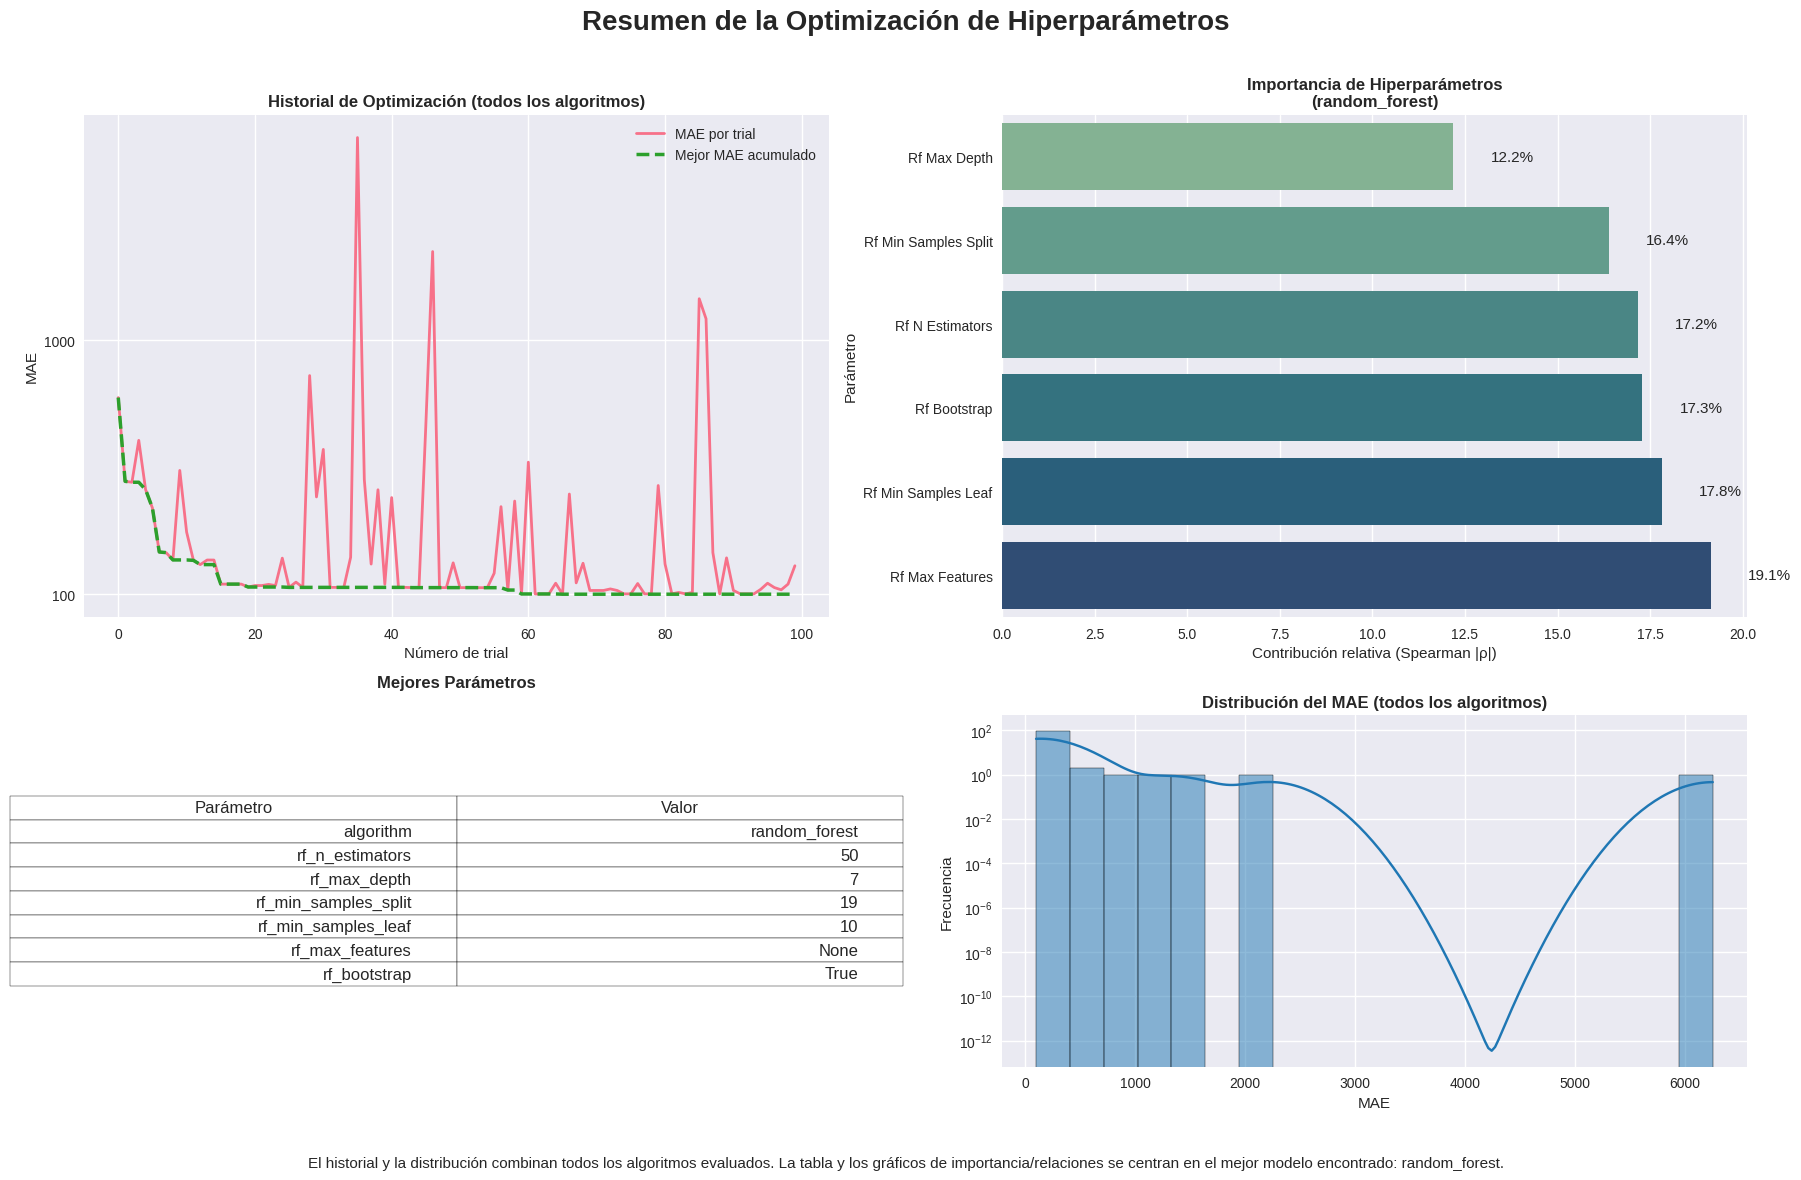

In [75]:
plot_optimization_summary(study)

/tmp/ipykernel_42051/3204294652.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_sorted, y='Algorithm', x='Mejor MAE', ax=ax_bar, palette='mako')


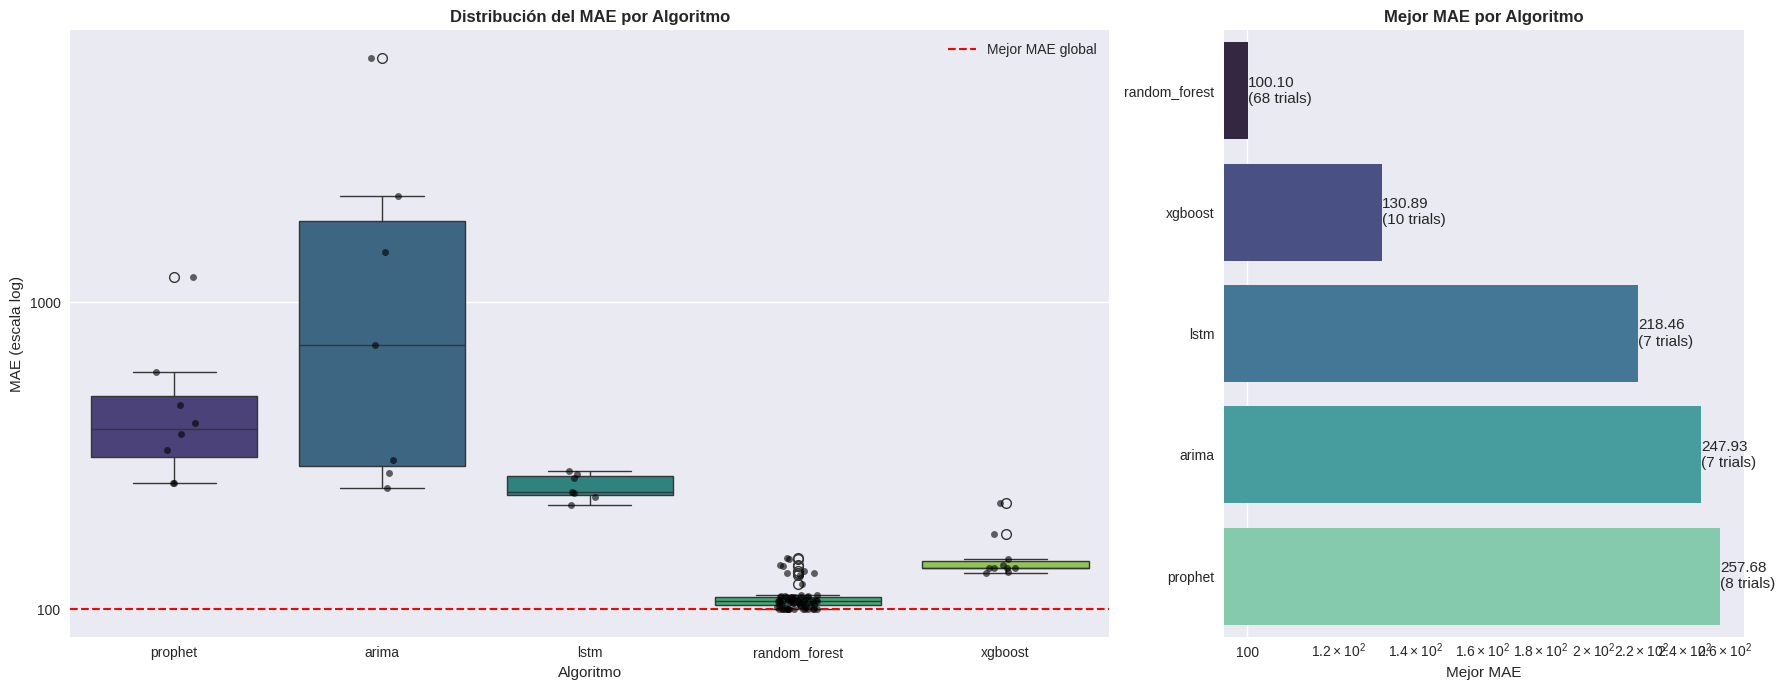

In [76]:
plot_algorithm_comparison(study)

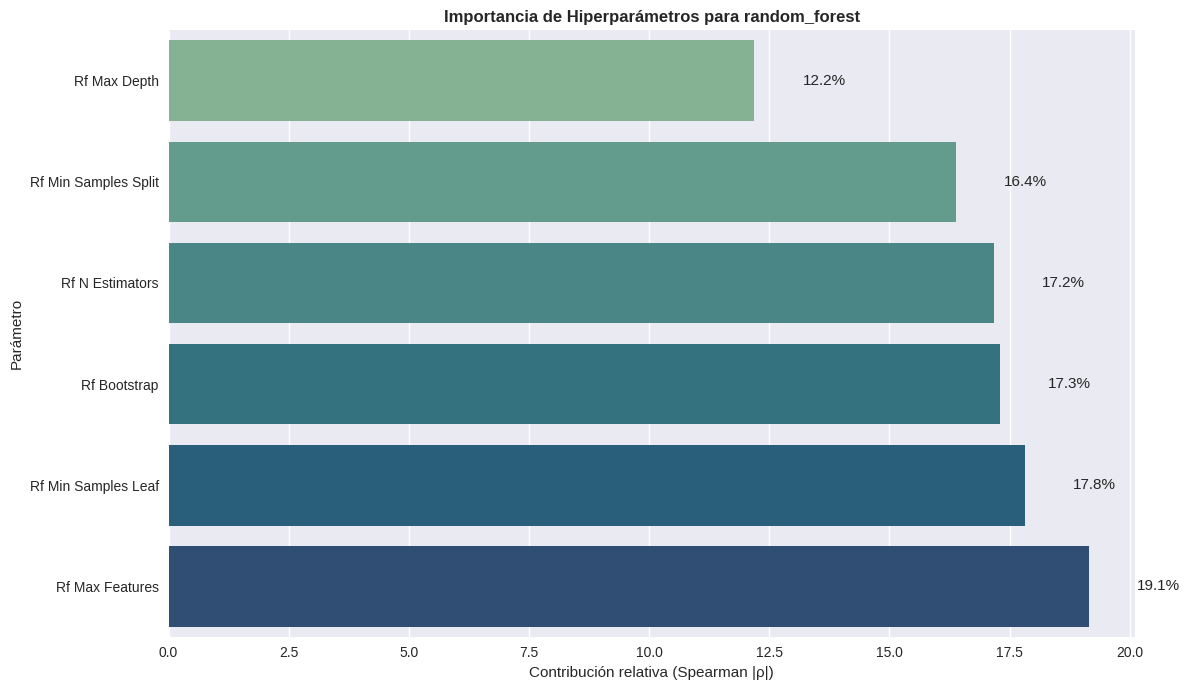

In [77]:
plot_hyperparameter_importance(study)

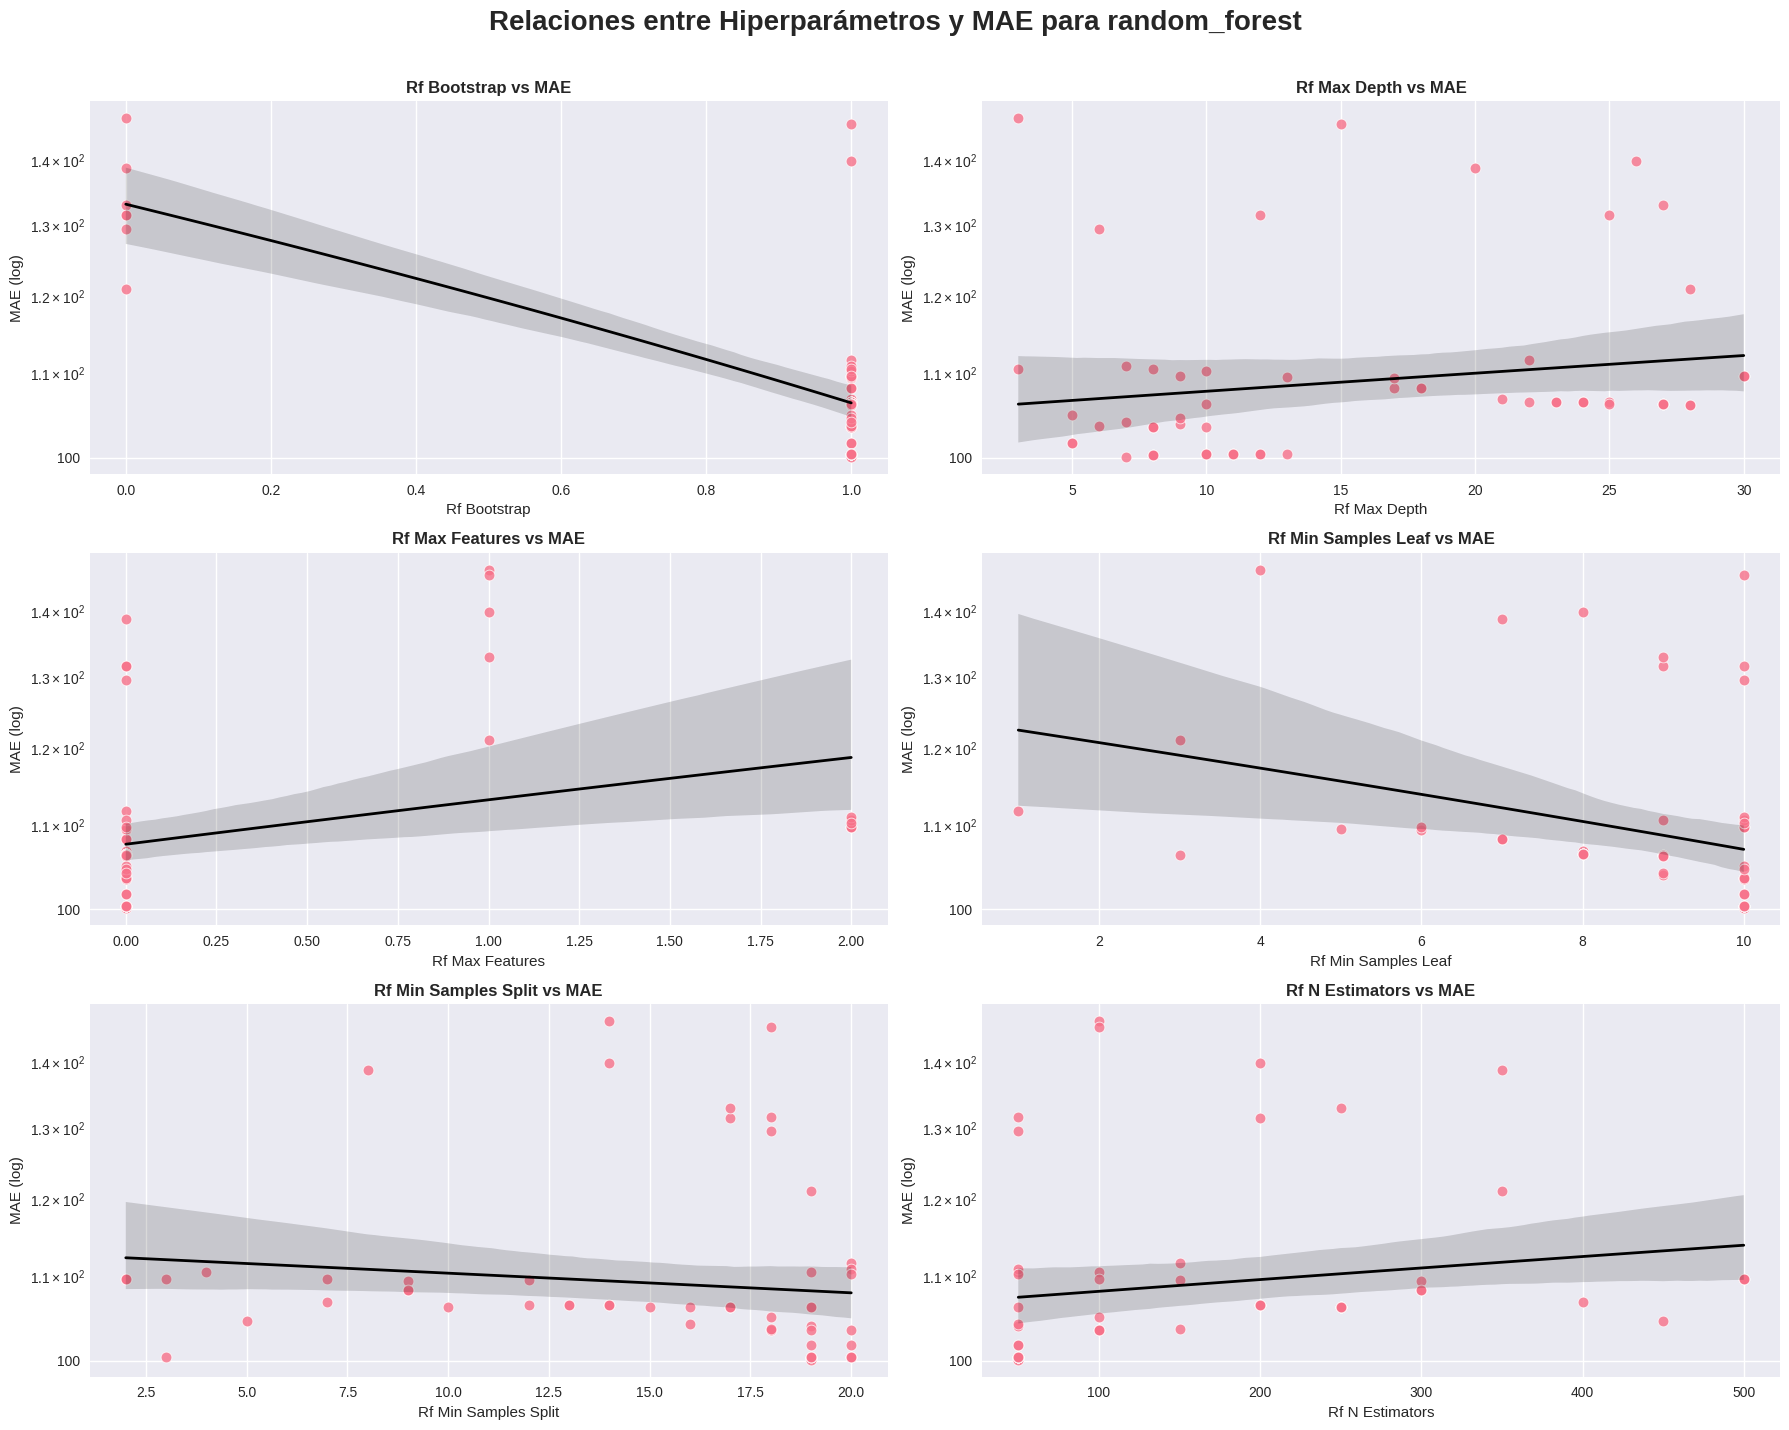

In [78]:
plot_hyperparameter_relationships(study)

/home/gabo/Personal/Universidad/04 - Cuarto Año/1er Semestre/Machine Learning/Proyectos/ml-project/models/preprocessing.py:123: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_reindexed = df_reindexed.fillna(method='ffill').fillna(method='bfill')
/home/gabo/Personal/Universidad/04 - Cuarto Año/1er Semestre/Machine Learning/Proyectos/ml-project/models/features.py:304: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[recovery_mask, 'covid_impact'] = 0.5


Generando curva de aprendizaje con 20 puntos...


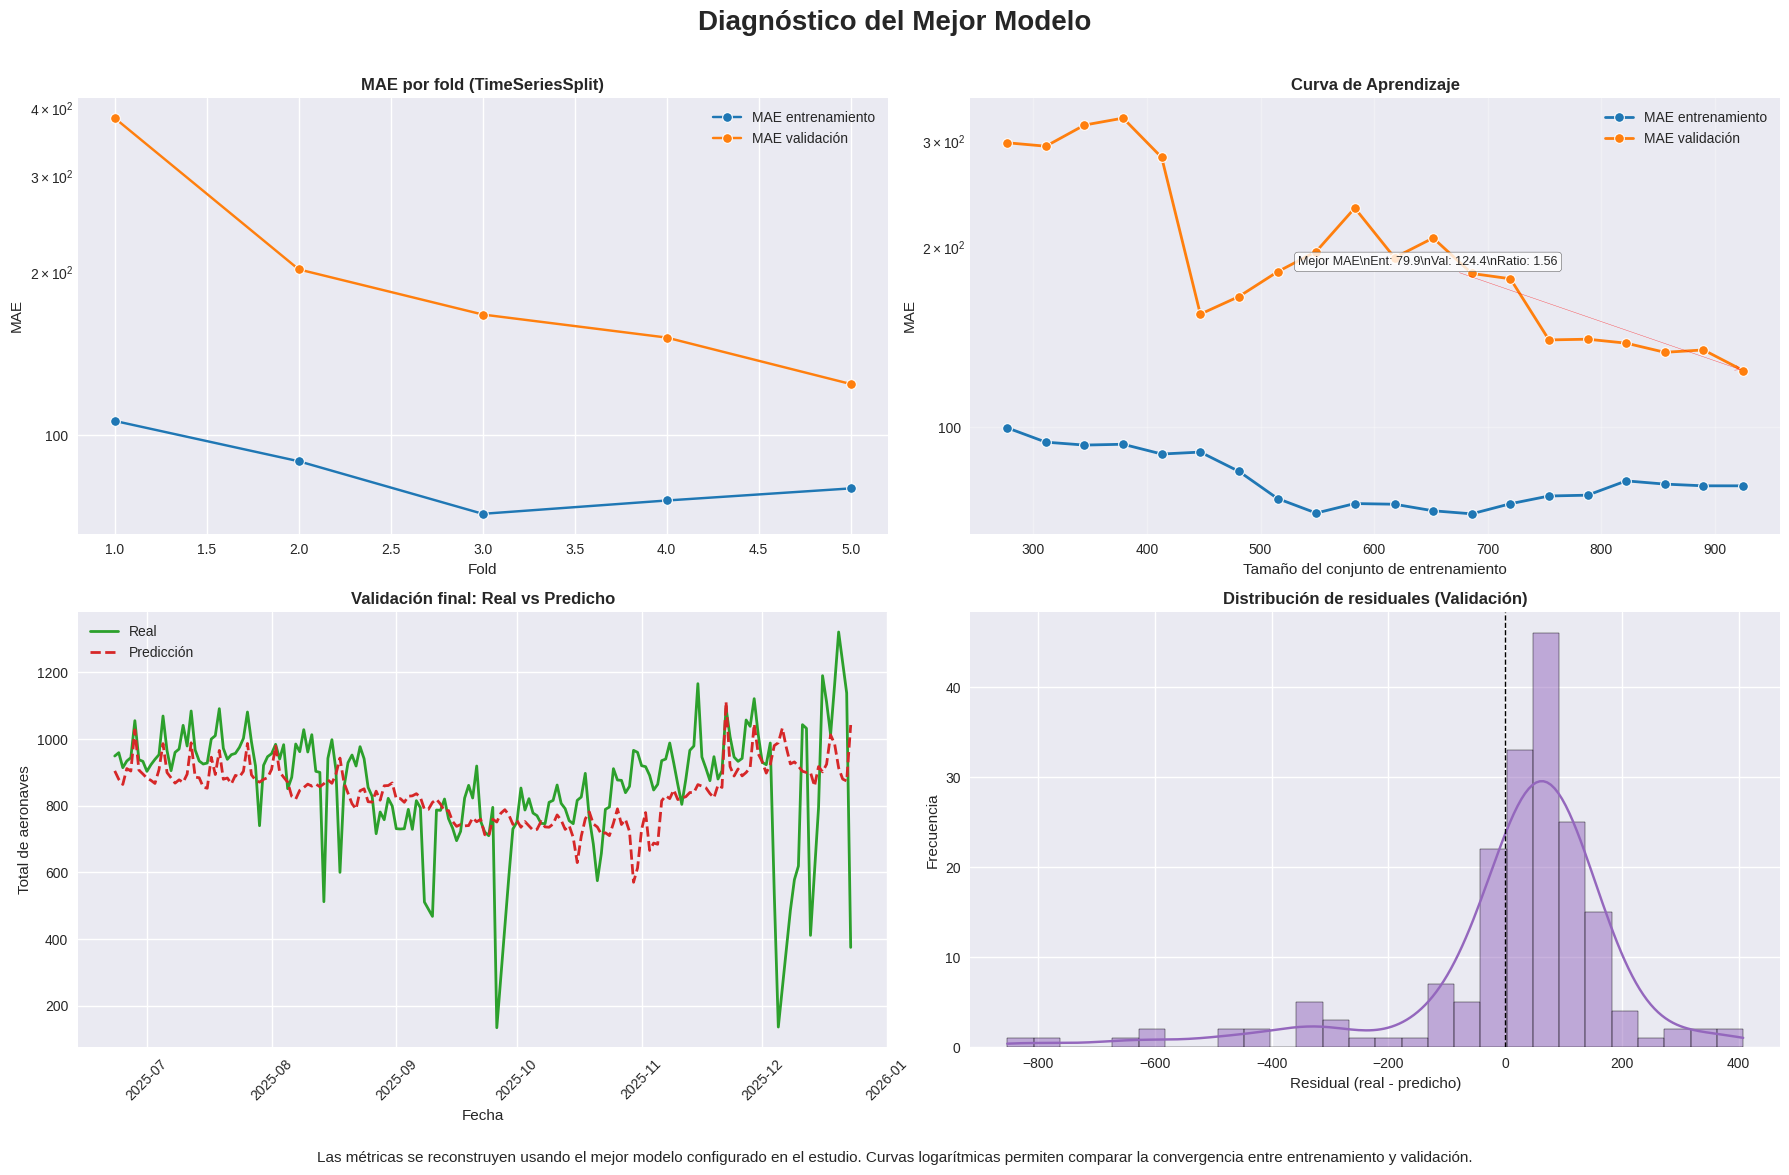

In [79]:
plot_best_model_learning_diagnostics(study)